<a href="https://colab.research.google.com/github/Hing-9/popup_store/blob/main/Popup_Store_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "효과적인 팝업스토어 연계를 위한 정보 제공방안 연구" Flow Chart.
##1. Transformer를 활용하여 NER로 1차 추출
- 사용 모델 : "monologg/koelectra-base-v3-naver-ner"
- 추가적으로 AI-Hub의 구어체 데이터 사용할 것인지 생각
- 어떤 Tag까지 브랜드 명으로 볼건지 확인

##2. ChatGPT API를 활용하여 2차 추출
- NER로 추출한 후보군 및 전체 context를 입력하여 Quest-Answer로 보정
- 적절한 Prompt 구성이 중요

###====================================

- 여기까지 "브랜드명", "판매품목", "위치", "기간"을 추출
- 사람이 마지막으로 최종 결정을 내리는 것으로

###====================================

##3. 브랜드명으로 감성분석 진행
- Naver Cloud AI 참조

##4. Kakao API로 해당 위치의 정보를 추출
- 기본적으로 주변 지하철 정보, 비슷한 업종의 분포
- 공공데이터로 인구이동정보, 교통정보

##5. 오픈기간의 시계열 정보를 활용
- 날씨, 계절

#환경설정

## Library Download

In [1]:
!pip install transformers
!pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Library Import

In [2]:
import pandas as pd
import re
import ast
import json
from tqdm import tqdm
import time

from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoModel, pipeline
import torch
import openai

from difflib import SequenceMatcher
from datetime import datetime

## Google Drive Connect

In [3]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Graduation-Thesis/NER

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Graduation-Thesis/NER


## 데이터 Load

In [4]:
dataset = pd.read_csv("main_df.csv", index_col=0, sep="|").dropna()
dataset

,url,content,date,ner_result,gpt_result
0,https://www.instagram.com/p/Ca899gVsqTA/,"봄향기 가득한 디즈니의 봄, 스프링블라썸 팝업스토어가자! 봄 내음이 솔솔 나는 지금...",2022-03-11,"{'brandNm': ['디즈니가', '파르나스몰에서', '디즈니랑', '파르나스몰...","{""brandNm"": ""디즈니"", ""product"": [""스프링블라썸"", ""푸"", ..."
1,https://www.instagram.com/p/Bt7bxYWA34D/,2/1~2/28 카페슈슈 in 신세계 강남 부산 용호동 JMT 마늘빵 카페슈슈가 신...,2019-02-16,"{'brandNm': ['신세계', 'JMT', '카페슈슈'], 'date': ['...","{""brandNm"": ""카페슈슈"", ""product"": [""JMT 마늘빵"", ""슈슈..."
2,https://www.instagram.com/p/B385GdSHnBh/,가로수길에 메르세데스-벤츠의 미래 모빌리티와 미래도시를 경험할 수 있는 특별한 EQ...,2019-10-23,"{'brandNm': ['벤츠의', '메르세데스-벤츠의', 'EQ', '퓨처', '...","{""brandNm"": ""메르세데스-벤츠"", ""product"": ""더 뉴 메르세데스-..."
3,https://www.instagram.com/p/CP0DnIpJFiw/,미끄러지지않는 옷걸이 마와 팝업스토어가자! 독일 발명가 바그너가 탄생시킨 70년 역...,2021-06-07,"{'brandNm': ['카톡', '마와!'], 'date': ['05.17(월)-...","{""brandNm"": ""마와"", ""product"": ""옷걸이"", ""location""..."
4,https://www.instagram.com/p/CnqgWQis0Qj/,1월 넷째 주 핫한 팝업 모음. zip WINTER CAMP 강남구 영동대로 114...,2023-01-22,"{'brandNm': ['삼성점1F', '영동대로', '더현대', 'Rola', '...","{""brandNm"":""zip WINTER CAMP, 레고, 에스더버니, Mansio..."
...,...,...,...,...,...
824,https://www.instagram.com/p/Cq9hISEvkFQ/,팝가가 미리 알려주는 업커밍 팝업스토어 KWANI & Heavenly Jelly &...,2023-04-13,"{'brandNm': ['&', 'Heavenly', '연무장17길', '헤븐리젤리...","{""brandNm"": [""KWANI"", ""Heavenly Jelly"", ""Came ..."
825,https://www.instagram.com/p/CqXXGdAPrAw/,내 안의 작은 카페 : KANU HOUSE 지하1층부터 5층 루프탑까지..카누로 가...,2023-03-31,"{'brandNm': ['루프탑까지..카누로', '카누의', 'KANU', '서울숲...","{""brandNm"": ""카누"", ""product"": ""캡슐 원두"", ""locatio..."
826,https://www.instagram.com/p/B3GRxE-HEyN/,완전체와 완전체의 콜라보! 카카오프렌즈와 나이키가 만나 홍대에 팝업스토어를 오픈했대...,2019-10-02,"{'brandNm': ['카카오프렌즈', '카카오프렌즈와', '나이키', '나이키가...","{""brandNm"": [""카카오프렌즈"", ""나이키""], ""product"": [""카카..."
827,https://www.instagram.com/p/B1nQQZhHbHQ/,"- 친환경 프리미엄 리빙브랜드, 코알라에코의 팝업스토어 오픈 소식! 키친, 욕실용품...",2019-08-26,"{'brandNm': ['코알라에코의', '에코', '코알라', '신세계'], 'd...","{""brandNm"": ""코알라에코"", ""product"": ""친환경 리빙 아이템"", ..."


# 1. 기존 Electra 모델의 사전 학습된 NER로 Tagging 해보기

- HuggingFace의 학습된 monologg/koelectra-base-v3-naver-ner 모델을 사용

In [ ]:
model_name = 'monologg/koelectra-base-v3-naver-ner'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)
ner = pipeline("ner",
               model=model,
               tokenizer=tokenizer,
               ignore_labels=[]  # To show every token result
               )

In [ ]:
def get_tags(text) : 

    # 입력받은 텍스트를 선언한 pipeline(ner())으로 Token 분류
    output = ner(text)

    # 결과를 ['팝', '###업', '###스' ...]이 아닌, 어절 단위(띄어쓰기 기준)로 나오도록 변경하는 작업
    words = text.split()
    tokens_mask = []
    for word in words:
        word_tokens = tokenizer.tokenize(word)
        if not word_tokens:
            word_tokens = [tokenizer.unk_token]  # For handling the bad-encoded word
        tokens_mask.extend([1] + [0] * (len(word_tokens) - 1))

    assert len(tokens_mask) == len(output)

    word_idx = 0
    word_list = []
    candi_word_list = []
    date_list = []
    loc_list = []

    for mask, token in zip(tokens_mask, output):
        if mask == 1:
            token['word'] = words[word_idx]
            word_idx += 1

            # 개채명은 'ORG-B', 'ORG-I'등으로 나오므로, BIO표현을 제외함.
            token['entity'] = token['entity'][:3]
            
            if token['entity'] != 'O' :
                word_list.append(token)

            if token['entity'] in ['ORG', 'EVT', 'AFW'] : # 개체명 중 브랜드에 가까운 개체명을 추출 (추가고려대상 : AFW, CVL)
                if '백화점' not in token['word'] :
                    candi_word_list.append(token['word'])
                else :
                    loc_list.append(token['word'])
            
            if token['entity'] in ['DAT'] :
                date_list.append(token['word'])
            
            if token['entity'] in ['LOC'] :
                loc_list.append(token['word'])

    result = {
        # 'all_tags' : word_list,
        'brandNm' : list(set(candi_word_list)),
        'date' : date_list,
        'location' : loc_list
    }

    return result

- (참조) Naver Ner 태그 구분

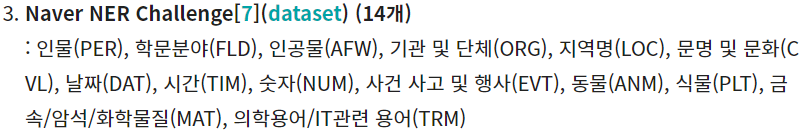

In [ ]:
dataset['ner_result'] = dataset['content'].apply(get_tags)

In [ ]:
dataset

# 2. ChatGPT API를 활용하여 NER Tagging 해보기

## Chat Response 추출

- 18$까지는 공짜라던데..

- 약 800개 돌리면 0.8$ 정도 나오는듯?

In [ ]:
openai.api_key = '' #Open AI API키 입력

### Prompt 생성

(참고) Prompt 양식
- You are the assistant who extracts words from a given pop-up store-related sentence. The words to extract are as follows. 1. Brand name, 2. Product category 3. Location, 4. Period. In addition, the output form is provided in the form of python dictionary as follows. {"brandNm": (1.), "product": (2.), "location": (3.), "date": (4.)}. If extraction is not possible, mark "null". If the result is multiple, make it into an array with "[]".'
- 당신은 정해진 팝업스토어 관련 문장에서 단어를 추출하는 어시스턴트입니다. 추출할 단어는 다음과 같습니다. 1. 브랜드명, 2. 상품 카테고리 3. 위치, 4. 기간. 또한 출력 형식은 다음과 같이 python 딕셔너리 형식으로 제공됩니다. {"brandNm": (1.), "product": (2.), "location": (3.), "date": (4.)}. 추출이 불가능한 경우 "null"로 표시합니다. 결과가 여러 개일 경우 "[]"와 함께 배열로 만듭니다

In [ ]:
def get_gpt(text) :
    
    messages = [
        {'role':'system', 'content':'You are the assistant who extracts words from a given pop-up store-related sentence. The words to extract are as follows. 1. Brand name, 2. Product category 3. Location, 4. Period. In addition, the output form is provided in the form of python dictionary as follows. {"brandNm": (1.), "product": (2.), "location": (3.), "date": (4.)}. If extraction is not possible, mark "null". If the result is multiple, make it into an array with "[]".'},
        {'role':'user', 'content':text}
    ]

    completion = openai.ChatCompletion.create(
        model = 'gpt-3.5-turbo',
        messages=messages
    )

    chat_response = completion.choices[0].message.content
    return chat_response

In [ ]:
# GPT 응답분 리셋
# dataset['gpt_result'] = ''
# dataset

,url,content,date,ner_result,gpt_result
0,https://www.instagram.com/p/Ca899gVsqTA/,"봄향기 가득한 디즈니의 봄, 스프링블라썸 팝업스토어가자! 봄 내음이 솔솔 나는 지금...",2022-03-11,"{'brandNm': ['디즈니가', '파르나스몰에서', '디즈니랑', '파르나스몰...",
1,https://www.instagram.com/p/Bt7bxYWA34D/,2/1~2/28 카페슈슈 in 신세계 강남 부산 용호동 JMT 마늘빵 카페슈슈가 신...,2019-02-16,"{'brandNm': ['신세계', 'JMT', '카페슈슈'], 'date': ['...",
2,https://www.instagram.com/p/B385GdSHnBh/,가로수길에 메르세데스-벤츠의 미래 모빌리티와 미래도시를 경험할 수 있는 특별한 EQ...,2019-10-23,"{'brandNm': ['벤츠의', '메르세데스-벤츠의', 'EQ', '퓨처', '...",
3,https://www.instagram.com/p/CP0DnIpJFiw/,미끄러지지않는 옷걸이 마와 팝업스토어가자! 독일 발명가 바그너가 탄생시킨 70년 역...,2021-06-07,"{'brandNm': ['카톡', '마와!'], 'date': ['05.17(월)-...",
4,https://www.instagram.com/p/CnqgWQis0Qj/,1월 넷째 주 핫한 팝업 모음. zip WINTER CAMP 강남구 영동대로 114...,2023-01-22,"{'brandNm': ['삼성점1F', '영동대로', '더현대', 'Rola', '...",
...,...,...,...,...,...
824,https://www.instagram.com/p/Cq9hISEvkFQ/,팝가가 미리 알려주는 업커밍 팝업스토어 KWANI & Heavenly Jelly &...,2023-04-13,"{'brandNm': ['&', 'Heavenly', '연무장17길', '헤븐리젤리...",
825,https://www.instagram.com/p/CqXXGdAPrAw/,내 안의 작은 카페 : KANU HOUSE 지하1층부터 5층 루프탑까지..카누로 가...,2023-03-31,"{'brandNm': ['루프탑까지..카누로', '카누의', 'KANU', '서울숲...",
826,https://www.instagram.com/p/B3GRxE-HEyN/,완전체와 완전체의 콜라보! 카카오프렌즈와 나이키가 만나 홍대에 팝업스토어를 오픈했대...,2019-10-02,"{'brandNm': ['카카오프렌즈', '카카오프렌즈와', '나이키', '나이키가...",
827,https://www.instagram.com/p/B1nQQZhHbHQ/,"- 친환경 프리미엄 리빙브랜드, 코알라에코의 팝업스토어 오픈 소식! 키친, 욕실용품...",2019-08-26,"{'brandNm': ['코알라에코의', '에코', '코알라', '신세계'], 'd...",


In [ ]:
# 완료되면 지우는 형식이라서 copy 사용.
dataset_gpt = dataset.copy() 

In [ ]:
# df_popup = pd.DataFrame(columns=['brandNm', 'product', 'location', 'date', 'post_date']) #처음 시작 시 사용
df_popup = pd.read_csv("popup_info_df.csv", index_col=0, sep="|").dropna() #저장된 데이터가 있을 경우 사용

#### API 호출
- Row당 최대 3번 반복하여 호출
- 매번 다른 대답이기 때문에, 전처리 시 오류처리 날 경우에는 새롭게 받음.

In [ ]:
for index, data in dataset_gpt[dataset_gpt['gpt_result']==''].iterrows() :
    print(f'Start.. Index : {index}')

    # 정상적으로 데이터를 받아 df_popup에 적재했다면, 3번 도는 for문과, Row별 도는 for문 모두를 나가야 하기 때문에 필요한 변수임.
    flag = False 

    for i in range(3) :
        print(f'Start.. Loop : {i}')
        try :
            test_text = get_gpt(data['content'])
        except :
            time.sleep(1)
            continue

        # 텍스트 전처리
        test_text.replace('\n', ' ') #Enter 제거
        test_text = re.sub('\s+', ' ', test_text) #연속 스페이스 제거

        # 딕셔너리 형태가 필요하므로 {로 시작하는 텍스트 부터 전처리 진행
        start_idx = test_text.find('{')
        if start_idx == -1 :
            continue
        else :
            test_text = test_text[start_idx:]

        # 딕셔너리 형태의 문자열이라면 json 파싱이 될 것!
        try :
            result = json.loads(test_text)
        except :
            continue

        result_arr = []
        if ((type(result['brandNm']) == list) and #value안에 여러개가 있을 때(ex. 5월 팝업 모음집)
            (result['location'] == list and result['date'] == list) and
            (len(result['brandNm']) == len(result['location']) == len(result['date']))) : #product를 제외하고는 모두 길이가 같을 경우에만 진행(GPT가 순서대로 넣었다는 가정 하에)

            tmp_dict = {}
            for i in range(len(result['brandNm'])) :
                tmp_dict = {
                    'brandNm' : result['brandNm'][i],
                    'product' : result['product'],
                    'location' : result['location'][i],
                    'date' : result['date'][i],
                }
                result_arr.apend(tmp_dict)
        else :
            result_arr.append(result)

        for each_result in result_arr :
            each_result = dict(zip(['brandNm', 'product', 'location', 'date'], list(each_result.values())))
            
            # Key값이 되는 브랜드이름이 없을 경우, Pass.
            if (not each_result['brandNm']) or (each_result['brandNm'] in ['None', 'null']) :
                continue

            each_result['post_date'] = data['date']
            each_result['origin_data_index'] = index
            df_popup = df_popup.append(each_result, ignore_index = True)
            flag = True

        if flag :
            dataset_gpt = dataset_gpt.drop(index, axis=0)
            break

    if flag :
        # 원 데이터에 결과값 저장
        dataset['gpt_result'][index] = each_result

        # csv Update
        df_popup.to_csv('popup_info_df.csv', sep='|')

In [ ]:
# csv로 저장
df_popup.to_csv('popup_info_df.csv', sep='|')
df_popup

## 데이터 정제

In [106]:
df_popup = pd.read_csv("popup_info_df.csv", index_col=0, sep="|")
df_popup

,brandNm,product,location,date,post_date,origin_data_index
0,디즈니,스프링블라썸,삼성동 파르나스몰,03.10(목)-03.27(일),2022-03-11,0.0
1,카페슈슈,마늘빵,"['신세계강남', '부산용호동']",2/1~2/28,2019-02-16,1.0
2,메르세데스-벤츠,"['미래 모빌리티', '미래도시', 'EQ', '순수 전기차', '더 뉴 메르세데스...",강남구 도산대로 15길 35,19.10.23 ~ 20.01.19,2019-10-23,2.0
3,마와,옷걸이,롯데백화점 강남점,05.17(월)-06.13(일),2021-06-07,3.0
4,"['zip WINTER CAMP', '레고', '에스더버니', 'Mansion de...","['null', 'null', 'null', 'null', 'null']","['강남구 영동대로 114길 5 이브자리 코디센 삼성점1F', '송파구 올림픽로 3...",['01.13(금)-01.29(일) 월-토: 10:30~21:00 일요일 및 공휴일...,2023-01-22,4.0
...,...,...,...,...,...,...
842,"['KWANI', 'Heavenly Jelly', 'Came Upon']","['의류', '가방', '액세서리']",성동구 연무장17길 4,04.14(금) -04.23(일),2023-04-13,824.0
843,KANU,다양한 제품,성동구 서울숲4길 15-1,03.25(토)-05.21(일) 매일: 11:00~20:00,2023-03-31,825.0
844,"['카카오프렌즈', '나이키']","['컬렉션', '조이라이드']",홍대,9.24~10.6,2019-10-02,826.0
845,코알라에코,"['키친', '욕실용품', '핸드워시']",신세계 백화점 대구점,8/8~9/4,2019-08-26,827.0


### 복수 데이터 제거
- 하나의 Post에 여러개의 Row가 만들어질 수 없다는 가정
 - 위에서 브랜드명, 위치, 날짜의 추출된 데이터 개수가 모두 같다면 나눠서 넣어주긴 했음!
- 여러 건이면 제외한다 (추후 수동으로 분배할지도 생각)

In [107]:
print(f'###### 전처리 전 데이터 개수 : {len(df_popup)}') #847

for index, data in df_popup.iterrows() :

    # 배열은 제외 (일단은..)
    for colNm in ['brandNm', 'location', 'date'] :
        if (data[colNm].find('[')!=-1) and (data[colNm].find(']')!=-1) :
            df_popup = df_popup.drop(index, axis=0)
            break

print(f'###### 전처리 후 데이터 개수 : {len(df_popup)}')

###### 전처리 전 데이터 개수 : 847
###### 전처리 후 데이터 개수 : 670


### date 컬럼
 - start_ymd, end_ymd date_diff로 분리 (시작일, 종료일, 기간)

In [113]:
def extract_date(date_string) :

    date_string = re.sub('\s+', '', date_string) #연속 스페이스 제거

    match0 = re.search(r'\d{2,4}[./-](\d{1,2})[./-](\d{1,2})\D+\d{2,4}[./-](\d{1,2})[./-](\d{1,2})', date_string)
    match1 = re.search(r'\d{2,4}[./-](\d{1,2})[./-](\d{1,2})\D+(\d{1,2})[./-](\d{1,2})', date_string)
    match2 = re.search(r'(\d{1,2})[./-](\d{1,2})\D+(\d{1,2})[./-](\d{1,2})', date_string)
    match3 = re.search(r'(\d{1,2})[월](\d{1,2})[일]\D+(\d{1,2})[월](\d{1,2})[일]', date_string)
    # match4 = re.search(r'(\d{1,2})[./-](\d{1,2})[~-](\d{1,2})$', date_string)

    # print("start!! "+date_string)

    all_date_arr = []

    if match0:
        for i in range(1, 5) :
            all_date_arr.append(match0.group(i))
    elif match1:
        for i in range(1, 5) :
            all_date_arr.append(match1.group(i))
    elif match2:
        for i in range(1, 5) :
            all_date_arr.append(match2.group(i))
    elif match3:
        for i in range(1, 5) :
            all_date_arr.append(match3.group(i))
    # elif match4:
    #     all_date_arr = [match4.group(1), match4.group(2), match4.group(1), match4.group(3)]
    else: 
        # print('out~')
        return None

    # print(all_date_arr)
    start_date = all_date_arr[0].zfill(2) + all_date_arr[1].zfill(2)
    end_date = all_date_arr[2].zfill(2) + all_date_arr[3].zfill(2)

    # print([start_date, end_date])

    return [start_date, end_date]

In [114]:
print(f'###### 전처리 전 데이터 개수 : {len(df_popup)}') #670
df_popup['start_ymd'] = ''
df_popup['end_ymd'] = ''
df_popup['date_diff'] = ''
for index, data in df_popup.iterrows() :
    mmdd_arr = extract_date(data['date'])

    if not mmdd_arr : 
        continue
    
    if int(mmdd_arr[0][:2]) > int(mmdd_arr[1][:2]) :
        start_ymd = data['post_date'][:4]+mmdd_arr[0]
        end_ymd = str(int(data['post_date'][:4])+1)+mmdd_arr[1]
    else :
        start_ymd = data['post_date'][:4]+mmdd_arr[0]
        end_ymd = data['post_date'][:4]+mmdd_arr[1]

    try :
        start_ymd_tmp = datetime.strptime(start_ymd, "%Y%m%d")
        end_ymd_tmp = datetime.strptime(end_ymd, "%Y%m%d")
        date_diff = end_ymd_tmp - start_ymd_tmp

        if date_diff.days < 0 :
            print('error : '+str(index))
            continue

        # 데이터에 결과값 저장
        df_popup['start_ymd'][index] = start_ymd
        df_popup['end_ymd'][index] = end_ymd
        df_popup['date_diff'][index] = date_diff.days
    except : 
        continue
    
print(f'###### 전처리 후 데이터 개수 : {len(df_popup[df_popup["start_ymd"]!=""])}')

###### 전처리 전 데이터 개수 : 670


<ipython-input-114-a8de0a5cdbc0>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['start_ymd'][index] = start_ymd
<ipython-input-114-a8de0a5cdbc0>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['end_ymd'][index] = end_ymd
<ipython-input-114-a8de0a5cdbc0>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['date_diff'][index] = date_diff.days


###### 전처리 후 데이터 개수 : 600


In [64]:
for index, data in df_popup[df_popup['start_ymd']==''].iterrows() :
    print(data[['date','post_date']])
    mmdd_arr = input("Input 'MMDD, MMDD' Here : ").split(',') # 수기처리
    print('='*60)
    
    if len(mmdd_arr) < 2 :
        df_popup = df_popup.drop(index, axis=0)
        continue
    
    if int(mmdd_arr[0][:2]) > int(mmdd_arr[1][:2]) :
        start_ymd = data['post_date'][:4]+mmdd_arr[0]
        end_ymd = str(int(data['post_date'][:4])+1)+mmdd_arr[1]
    else :
        start_ymd = data['post_date'][:4]+mmdd_arr[0]
        end_ymd = data['post_date'][:4]+mmdd_arr[1]

    start_ymd_tmp = datetime.strptime(start_ymd, "%Y%m%d")
    end_ymd_tmp = datetime.strptime(end_ymd, "%Y%m%d")
    date_diff = end_ymd_tmp - start_ymd_tmp

    if date_diff.days < 0 :
        print('error : '+str(index))
    
    # 데이터에 결과값 저장
    df_popup['start_ymd'][index] = start_ymd
    df_popup['end_ymd'][index] = end_ymd
    df_popup['date_diff'][index] = date_diff.days

date         2021-3-22~2021-3-28
post_date             2019-03-22
Name: 87, dtype: object
Input 'MMDD, MMDD' Here : 0322,0328


<ipython-input-64-a934cfe5b45a>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['start_ymd'][index] = start_ymd
<ipython-input-64-a934cfe5b45a>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['end_ymd'][index] = end_ymd
<ipython-input-64-a934cfe5b45a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popup['date_diff'][index] = date_diff.days


date         2022-05-05 ~ 2022-06-19
post_date                 2022-05-13
Name: 100, dtype: object


KeyboardInterrupt: ignored

### 동일값 판단하여 제거
- 기준
 - 브랜드 이름이 같고, 위치가 같은 경우
 - 브랜드 이름이 같고, 날짜가 같은 경우

In [ ]:
print(f'###### 전처리 전 데이터 개수 : {len(df_popup)}') #847

for index, data in df_popup.iterrows() :

    # 배열은 제외 (일단은..)
    if (data['brandNm'].find('[')!=-1) and (data['brandNm'].find(']')!=-1) :
        df_popup = df_popup.drop(index, axis=0)
        continue
    
    cond = df_popup['brandNm'] == data['brandNm']
    cond_1 = cond & (df_popup['location'] == data['location'])
    cond_2 = cond & (df_popup['date'] == data['date'])

    df_popup[cond_1].index

    print(df_popup[cond_1].index)

###### 전처리 전 데이터 개수 : 715
Int64Index([0], dtype='int64')
Int64Index([1], dtype='int64')
Int64Index([2], dtype='int64')
Int64Index([3], dtype='int64')
Int64Index([5], dtype='int64')
Int64Index([6], dtype='int64')
Int64Index([8], dtype='int64')
Int64Index([9], dtype='int64')
Int64Index([10], dtype='int64')
Int64Index([11], dtype='int64')
Int64Index([13], dtype='int64')
Int64Index([14], dtype='int64')
Int64Index([17], dtype='int64')
Int64Index([18], dtype='int64')
Int64Index([19], dtype='int64')
Int64Index([22], dtype='int64')
Int64Index([23], dtype='int64')
Int64Index([25], dtype='int64')
Int64Index([26], dtype='int64')
Int64Index([27], dtype='int64')
Int64Index([28], dtype='int64')
Int64Index([30], dtype='int64')
Int64Index([32], dtype='int64')
Int64Index([33], dtype='int64')
Int64Index([35], dtype='int64')
Int64Index([36], dtype='int64')
Int64Index([37], dtype='int64')
Int64Index([38], dtype='int64')
Int64Index([39], dtype='int64')
Int64Index([40], dtype='int64')
Int64Index([41], dtype

### 브랜드 이름을 기준으로 유사한 값 제거
 - 코사인 유사도를 통해 동일한 것으로 판단되는 데이터를 삭제한다.
 - 기준 : 유사도 0.5 이상인 데이터를 나열 후, 사람이 판단하여 해당 인덱스를 제거

In [ ]:
def similar(a, b) :
    return SequenceMatcher(None, a, b).ratio()

In [ ]:
df_popup_tmp = df_popup.copy()

In [ ]:
for index, data in df_popup_tmp.iterrows() :
    df_sim = pd.DataFrame(columns=['similar'])
    df_sim['similar'] = df_popup_tmp['brandNm'][index:].apply(similar, args=[data['brandNm']]) #유사도 계산
    # df_sim = df_sim.drop(index, axis=0)
    df_sim = df_sim.sort_values(by=['similar'], ascending=False)
    df_sim = df_sim[df_sim['similar']>=0.5]
    
    if len(df_sim) <= 1 :
        continue
    
    display(df_popup_tmp.loc[df_sim.index])
    drop_index = input('삭제할 인덱스를 나열하시오 : ')

    if len(drop_index) == 0 :
        continue
    
    drop_index_arr = drop_index.split(',')
    drop_index_arr = [int (i) for i in drop_index_arr]
    
    print(drop_index_arr)

    for idx in drop_index_arr :
        df_popup_tmp = df_popup_tmp.drop(idx, axis=0)

    print('='*60)

,brandNm,product,location,date,post_date,origin_data_index
0,디즈니,스프링블라썸,삼성동 파르나스몰,03.10(목)-03.27(일),2022-03-11,0.0
521,디즈니,굿즈,롯데몰 수지점,19.12.27(금) - 20.1.17(금),2019-12-27,606.0
170,디즈니,팝업스토어,"['송도점', '대전점', '김포점']","{'start': '2021-03-05', 'end': '2021-05-09'}",2021-03-08,196.0
97,디즈니,"['굿즈 자판기', '슐라이히의 동물 피규어']",성동구 서울숲4길 20,04.06(목) -04.23(일) 매일: 11:00-20:00,2023-04-14,110.0
481,디즈니,"['피규어', '인형', '필기구', '텀블러']","강남구 테헤란로 521, 파르나스몰 B1층 입구 라운지",02.28(화)-03.12(일),2023-02-28,560.0
89,디즈니,"['의류', '잡화', '문구', '인형', '굿즈']",롯데월드몰 지하1층 스위트스팟캐릭터샵,"['2월 21일', '3월 31일']",2020-02-21,102.0
425,디즈니,아트컬렉션,현대백화점 판교점,04.03(월)-04.16(일),2023-04-04,490.0
41,디즈니,악당 팝업스토어,잠실 롯데월드몰,10.3~10.31,2019-10-07,47.0
270,디즈니,"['아동 Family 상품', 'MZ 세대']",경기도 하남시 미사대로 750 신세계백화점 스타필드 하남점 1층 중앙광장,12.16(금)-12.29(목) 매일: 10:30-20:00 (금토일 21:00),2022-12-20,314.0
123,디즈니코리아,'러브 네이처' 캠페인,더현대서울,04.29(금)-05.05(목),2022-04-29,139.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
1,카페슈슈,마늘빵,"['신세계강남', '부산용호동']",2/1~2/28,2019-02-16,1.0
230,카페희다,"['생과일 우유', '두치커피']",강남구 압구정로 12길 22,9.5~9.28,2019-09-06,268.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
3,마와,옷걸이,롯데백화점 강남점,05.17(월)-06.13(일),2021-06-07,3.0
655,마블,메크스트라이크,"['하남 스타필드 지하1층', '고양 스타필드 pk 아트리움', '코엑스 스타필드 ...","['05.01(토)', '05.21(금)']",2021-05-07,757.0
36,푸마,"['스웨이드 스니커즈', 'T7 트랙 세트 트레이닝복']",성수동,03.30(목)-04.10(일),2022-04-05,40.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
189,LG,"['올레드 디스플레이', '레이싱', '크레이지 아케이드']","강남 성수동, 강남역",10.12(수)-11.27(일),2022-10-27,219.0
409,LG,오락실 게임,성수,10.21-12.19,2021-11-12,474.0
114,LG,전자제품,성수,4/7(목)-5/8(일),2022-04-14,129.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
472,"['우주먼지', '마일드무무']","['인형', '키링', '그립톡', '스티커']",더현대서울,04.05(수)-04.16(일),2023-04-05,549.0
113,"['스위트스팟', '무유무유']",팝업스토어,롯데월드몰 1층,09.01 - 10.31,2020-09-02,128.0
333,"['짱구', '스파오']","['굿즈', '초코비', '과자', '잠옷']",신촌점,09.24-10.03,2021-09-24,386.0
20,"['마텔', '손오공']",['완구'],판교 알파돔,12/20~12/24,2018-12-19,22.0
21,"['디즈니', '픽사']",캐릭터 굿즈,잠실 롯데월드몰 B1층,06.19 - 종료시까지,2020-06-23,23.0
172,"['아디다스', '구찌']",스포츠,강남구 언주로164길 21-3 꼴라보하우스 도산,06.08(수)-06.19(일) 매일 : 10:30~20:00,2022-06-14,199.0
285,"['탐스', '빅토리아']",신발,DDMC,12/12~12/14,2018-12-12,335.0
421,"['레고', '유플러스']","['희귀 제품', '미니 레고', '드레스코드', '신제품', '인기 제품']",강남구 강남대로 426 일상비일상의틈,07.20(수)-08.14(일),2022-07-26,486.0
289,"['제니', '젠틀몬스터']",안경/선글라스,강남구 압구정로 46길 50 하우스도산,03.18(금)-04.30(토),2022-03-30,340.0
639,"['비비고', '제주맥주']","['만두', '맥주']",강남구 언주로164길 21-3,10.10(월)-10.30(일),2022-10-13,741.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
311,로이스,생초콜릿,현대백화점 판교,3/8~3/14,2019-03-11,362.0
78,세이치즈토스트,치즈토스트,AK플라자 수원,4/12~4/25,2019-04-16,89.0
772,디앤에이모터스,전기스쿠터,파주 프리미엄 아울렛,4월 한 달 동안 매주 금토일,2021-04-02,747.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
386,"['LG', 'SK렌터카', '스텔라']","['오락실 게임', '라면', '비주얼 아트 전시']","['null', '한옥 인테리어', 'null']","['null', 'null', '궁예를 부탁해 이벤트']",2021-12-28,449.0
56,"['스위트스팟', '챔피온', '탐스', '아이헤이트먼데이']",편집숍,을지스타몰 을지지하상가,4/26,2019-04-26,63.0
388,"['OPI', '닥터올가', 'A24', '시크릿네이처']",코스메틱,상암DDMC,6/4~5,2019-06-04,451.0
400,"['올리브영', '구달', '라운드랩', '아누아']",클린뷰티,연남방앗간,03.18(금) - 03.27(일),2022-03-22,464.0
550,"['핑크홀리데이', '키르시', '서프코드', '캐치볼클럽']",굿즈,영등포구 여의대로 108 더현대 서울,05.14(토)-06.06(월),2022-05-30,643.0
516,"['레노마', '바쏘', '카운테스마라', '앤드지', '프랑코페라로']",남성복,부영을지빌딩 현대백화점 신촌과 팝업스토어플랫폼 스위트스팟이 을지로에서,2/25~2/28,2019-02-25,601.0
592,"['LF', '휠라', '르꼬끄', '질스튜어트', '닥스', '라푸마', '헤지스']",의류,서울특별시 마포구 매봉산로 75 DDMC 지하1층,1월20일(월) - 23일(목),2020-01-20,690.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
211,에스티듀퐁,"['슈즈', '셔츠', '타이 컬렉션']",하남,1월7일 - 1월 15일,2020-01-10,245.0
40,에스티로더,립케어,신사 가로수길,2/14~2/22,2019-02-14,46.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
333,"['짱구', '스파오']","['굿즈', '초코비', '과자', '잠옷']",신촌점,09.24-10.03,2021-09-24,386.0
21,"['디즈니', '픽사']",캐릭터 굿즈,잠실 롯데월드몰 B1층,06.19 - 종료시까지,2020-06-23,23.0
285,"['탐스', '빅토리아']",신발,DDMC,12/12~12/14,2018-12-12,335.0
172,"['아디다스', '구찌']",스포츠,강남구 언주로164길 21-3 꼴라보하우스 도산,06.08(수)-06.19(일) 매일 : 10:30~20:00,2022-06-14,199.0
421,"['레고', '유플러스']","['희귀 제품', '미니 레고', '드레스코드', '신제품', '인기 제품']",강남구 강남대로 426 일상비일상의틈,07.20(수)-08.14(일),2022-07-26,486.0
288,"['엘레쎄', '스티그마']",['팝업'],건대커먼그라운드,6/26~7/19,2019-07-03,339.0
603,"['피그웨이브', '꿉당']","['고깃집', '냉삼집', '냉동 삼겹살', '메추리알 떡볶이', '하이볼', '잡채']",강남구 선릉로155길 23-4 2층,03.15(수)-04.14(금),2023-04-01,702.0
470,"['필굿', '고래사어묵']","['어묵바', '맥주']",['성동구'],['12.02-12.18'],2022-12-06,545.0
587,"['르메르디앙', '목시']",['호텔'],"['서울 명동', '성동구']",['11.09-11.20'],2022-11-15,683.0
639,"['비비고', '제주맥주']","['만두', '맥주']",강남구 언주로164길 21-3,10.10(월)-10.30(일),2022-10-13,741.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
172,"['아디다스', '구찌']",스포츠,강남구 언주로164길 21-3 꼴라보하우스 도산,06.08(수)-06.19(일) 매일 : 10:30~20:00,2022-06-14,199.0
460,"['공간 와디즈', '제주맥주']","['비어가든', '제주맥주']",서울 성수동 연무장1길 7-1 공간와디즈 1층 야외마당,06.24(금)-06.26(일),2022-06-24,535.0
587,"['르메르디앙', '목시']",['호텔'],"['서울 명동', '성동구']",['11.09-11.20'],2022-11-15,683.0
470,"['필굿', '고래사어묵']","['어묵바', '맥주']",['성동구'],['12.02-12.18'],2022-12-06,545.0
289,"['제니', '젠틀몬스터']",안경/선글라스,강남구 압구정로 46길 50 하우스도산,03.18(금)-04.30(토),2022-03-30,340.0
333,"['짱구', '스파오']","['굿즈', '초코비', '과자', '잠옷']",신촌점,09.24-10.03,2021-09-24,386.0
708,"['카카오프렌즈', '나이키']","['컬렉션', '조이라이드']",홍대,9.24~10.6,2019-10-02,826.0
285,"['탐스', '빅토리아']",신발,DDMC,12/12~12/14,2018-12-12,335.0
421,"['레고', '유플러스']","['희귀 제품', '미니 레고', '드레스코드', '신제품', '인기 제품']",강남구 강남대로 426 일상비일상의틈,07.20(수)-08.14(일),2022-07-26,486.0
201,"['라인프렌즈', '던킨도너츠']",도너츠,현대백무역센터,11/27~12/9,2018-12-04,233.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
219,포켓몬,전체 상품,판교 현대백화점,03.04(금)~03.14(월),2022-03-04,254.0
688,포켓몬,"['봉제인형', '랜덤피규어', '컵', '게임기']",더현대서울 지하 1층,10.01(금)-10.07(목),2021-10-01,802.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
129,꿀하우스,카페,이태원,2/14~3/31,2019-02-21,145.0
296,에뛰드하우스,립스톡,명동,4/6~4/30,2019-04-14,347.0
433,크로우캐년홈,리빙 제품들,도레도레 신사점,11.9 ~ 11.17,2019-11-13,499.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
534,에스더버니,"['인형', '그립톡', '엽서', '굿즈']","영등포구 여의대로108, 더현대 서울 5층",01.06(금)-01.31(수),2023-01-18,623.0
53,에스더버니,"['인형', '담요', '문구류', '파우치']",신촌 현대백화점 유플렉스 B2층 팝 스트리트,11.8 ~ 11.24,2019-11-20,60.0
211,에스티듀퐁,"['슈즈', '셔츠', '타이 컬렉션']",하남,1월7일 - 1월 15일,2020-01-10,245.0
673,제이에스티나,뷰티,녹사평,5/31~6/23,2019-06-06,782.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
170,디즈니,팝업스토어,"['송도점', '대전점', '김포점']","{'start': '2021-03-05', 'end': '2021-05-09'}",2021-03-08,196.0
521,디즈니,굿즈,롯데몰 수지점,19.12.27(금) - 20.1.17(금),2019-12-27,606.0
89,디즈니,"['의류', '잡화', '문구', '인형', '굿즈']",롯데월드몰 지하1층 스위트스팟캐릭터샵,"['2월 21일', '3월 31일']",2020-02-21,102.0
270,디즈니,"['아동 Family 상품', 'MZ 세대']",경기도 하남시 미사대로 750 신세계백화점 스타필드 하남점 1층 중앙광장,12.16(금)-12.29(목) 매일: 10:30-20:00 (금토일 21:00),2022-12-20,314.0
97,디즈니,"['굿즈 자판기', '슐라이히의 동물 피규어']",성동구 서울숲4길 20,04.06(목) -04.23(일) 매일: 11:00-20:00,2023-04-14,110.0
425,디즈니,아트컬렉션,현대백화점 판교점,04.03(월)-04.16(일),2023-04-04,490.0
481,디즈니,"['피규어', '인형', '필기구', '텀블러']","강남구 테헤란로 521, 파르나스몰 B1층 입구 라운지",02.28(화)-03.12(일),2023-02-28,560.0
123,디즈니코리아,'러브 네이처' 캠페인,더현대서울,04.29(금)-05.05(목),2022-04-29,139.0
274,디즈니 코리아,마블 히어로,안성 스타필드,04.25(월)-05.08(일),2022-04-28,319.0
50,디즈니애니메이션,"['굿즈', '작품']",동대문DDP,4/19~8/18,2019-06-25,57.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
89,디즈니,"['의류', '잡화', '문구', '인형', '굿즈']",롯데월드몰 지하1층 스위트스팟캐릭터샵,"['2월 21일', '3월 31일']",2020-02-21,102.0
521,디즈니,굿즈,롯데몰 수지점,19.12.27(금) - 20.1.17(금),2019-12-27,606.0
270,디즈니,"['아동 Family 상품', 'MZ 세대']",경기도 하남시 미사대로 750 신세계백화점 스타필드 하남점 1층 중앙광장,12.16(금)-12.29(목) 매일: 10:30-20:00 (금토일 21:00),2022-12-20,314.0
170,디즈니,팝업스토어,"['송도점', '대전점', '김포점']","{'start': '2021-03-05', 'end': '2021-05-09'}",2021-03-08,196.0
97,디즈니,"['굿즈 자판기', '슐라이히의 동물 피규어']",성동구 서울숲4길 20,04.06(목) -04.23(일) 매일: 11:00-20:00,2023-04-14,110.0
481,디즈니,"['피규어', '인형', '필기구', '텀블러']","강남구 테헤란로 521, 파르나스몰 B1층 입구 라운지",02.28(화)-03.12(일),2023-02-28,560.0
425,디즈니,아트컬렉션,현대백화점 판교점,04.03(월)-04.16(일),2023-04-04,490.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
351,"['휠라', '탑텐', '탐스', '빅토리아키즈', '영풍문고']","['도서', '문구류']",상암DDMC,2/18~2/22,2019-02-18,408.0
400,"['올리브영', '구달', '라운드랩', '아누아']",클린뷰티,연남방앗간,03.18(금) - 03.27(일),2022-03-22,464.0
653,"['나이키', '아디다스', '컨버스', '아웃도어 타키']",['스포츠'],상암DDMC,3/4~3/8,2019-03-04,755.0
79,"['스위트스팟X룬', '산드로', '마쥬', '누디진', '자딕앤볼테르', '헬무트랭']",컨템포러리,강남역,3/2~3/31,2019-03-02,90.0
544,"['스위트스팟', '브랜디']",의류,강남역 5번출구,1/28~2/28,2019-01-29,635.0
388,"['OPI', '닥터올가', 'A24', '시크릿네이처']",코스메틱,상암DDMC,6/4~5,2019-06-04,451.0
113,"['스위트스팟', '무유무유']",팝업스토어,롯데월드몰 1층,09.01 - 10.31,2020-09-02,128.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
436,유니콘마켓,플리마켓,인천공항 제1터미널,5/23~26,2019-05-23,505.0
133,유니콘 마켓,플리마켓,용산 아이파크몰,10.28(월) - 11.03(일),2019-10-28,151.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
653,"['나이키', '아디다스', '컨버스', '아웃도어 타키']",['스포츠'],상암DDMC,3/4~3/8,2019-03-04,755.0
313,"['나이키', '아디다스', '퓨마', '리복', '컨버스']",다양한 제품들,상암 동아 디지털 미디어 센터[DDMC] B1층 행사장,10.21(월) - 10.25(금),2019-10-21,365.0
592,"['LF', '휠라', '르꼬끄', '질스튜어트', '닥스', '라푸마', '헤지스']",의류,서울특별시 마포구 매봉산로 75 DDMC 지하1층,1월20일(월) - 23일(목),2020-01-20,690.0
305,"['푸마', '아디다스', '뉴발란스', '나이키']","['겨울 의류', '잡화', '패딩', '파카', '워머', '런닝화']",서울특별시 마포구 매봉산로 75,1월8일(수) - 10일(금),2020-01-08,356.0
654,"['무신사 스탠다드', '헤지스', '오프세일', '젠틀몬스터x몽클레르', '29맨...","['슬랙스', 'null', '가로대전', 'null', 'null', 'null'...","['성동구 아차산로 78', '성동구 서울숲4길 17', '신사동 가로수길 36 가...","['04.29(금)-05.22(일) 매일 : 11:30~20:00', '05.05(...",2022-05-14,756.0
591,"['더데이걸', '코코리따', '다나한', '차랩', '에버셀', '세러데이스킨']","['키즈', '코스매틱']",DDMC 이랜드,4/22~4/26,2019-04-23,689.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
563,넷플렉스,"['팝업', '게임존', '트릭아트', '아케이드존']",홍대입구,6/20~7/7,2019-06-22,659.0
426,브릭스,"['벨라지오', '라이프 컬렉션']",신세계백화점 강남,6/5~6/13,2019-06-10,491.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
333,"['짱구', '스파오']","['굿즈', '초코비', '과자', '잠옷']",신촌점,09.24-10.03,2021-09-24,386.0
172,"['아디다스', '구찌']",스포츠,강남구 언주로164길 21-3 꼴라보하우스 도산,06.08(수)-06.19(일) 매일 : 10:30~20:00,2022-06-14,199.0
421,"['레고', '유플러스']","['희귀 제품', '미니 레고', '드레스코드', '신제품', '인기 제품']",강남구 강남대로 426 일상비일상의틈,07.20(수)-08.14(일),2022-07-26,486.0
285,"['탐스', '빅토리아']",신발,DDMC,12/12~12/14,2018-12-12,335.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
102,도리스돌,"['구체관절 인형', '의상', '신발']",현대백화점 중동점,12.20(금) - 26(목),2019-12-24,116.0
597,이탈리아,"['F&B', '화장품', '패션', '라이프스타일']",서울 강남구 압구정로 12길 22,19.12.11 - 20.10.31,2019-12-30,696.0
295,쓰리먼스,"['팝업', '스티커', '그립톡', '모찌인형', '캐릭터 굿즈']",홍대 오브젝트,5/14~6/15,2019-05-29,346.0
207,탈리다쿰,비건 뷰티,LCDC 서울,08.18(목)-09.29(목),2022-09-06,241.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
474,러버덕 프로젝트,"['러버덕', '팝업스토어']",서울 잠실 롯데타워몰,09.30(금)-10.31(월),2022-09-28,551.0
586,프로젝트ㄱ,"['굿모닝 독도', '우리 삽사리', '근화고국', '키링', '후드티', '휴대폰...",가로수길 by대한민국(강남구 압구정로 12길 22),9.5 - 9.28,2019-09-18,682.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
313,"['나이키', '아디다스', '퓨마', '리복', '컨버스']",다양한 제품들,상암 동아 디지털 미디어 센터[DDMC] B1층 행사장,10.21(월) - 10.25(금),2019-10-21,365.0
591,"['더데이걸', '코코리따', '다나한', '차랩', '에버셀', '세러데이스킨']","['키즈', '코스매틱']",DDMC 이랜드,4/22~4/26,2019-04-23,689.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
425,디즈니,아트컬렉션,현대백화점 판교점,04.03(월)-04.16(일),2023-04-04,490.0
97,디즈니,"['굿즈 자판기', '슐라이히의 동물 피규어']",성동구 서울숲4길 20,04.06(목) -04.23(일) 매일: 11:00-20:00,2023-04-14,110.0
521,디즈니,굿즈,롯데몰 수지점,19.12.27(금) - 20.1.17(금),2019-12-27,606.0
170,디즈니,팝업스토어,"['송도점', '대전점', '김포점']","{'start': '2021-03-05', 'end': '2021-05-09'}",2021-03-08,196.0
270,디즈니,"['아동 Family 상품', 'MZ 세대']",경기도 하남시 미사대로 750 신세계백화점 스타필드 하남점 1층 중앙광장,12.16(금)-12.29(목) 매일: 10:30-20:00 (금토일 21:00),2022-12-20,314.0
481,디즈니,"['피규어', '인형', '필기구', '텀블러']","강남구 테헤란로 521, 파르나스몰 B1층 입구 라운지",02.28(화)-03.12(일),2023-02-28,560.0
123,디즈니코리아,'러브 네이처' 캠페인,더현대서울,04.29(금)-05.05(목),2022-04-29,139.0
274,디즈니 코리아,마블 히어로,안성 스타필드,04.25(월)-05.08(일),2022-04-28,319.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
410,리카리카,"['인테리어', '옷', '쿠션', '아이템']",신세계 강남,4/5~4/7,2019-04-05,475.0
607,카카움,"['초콜릿', '책']","['반디앤루키스 센트럴시티점', '교보 핫트랙스']",2/2~2/14,2019-02-10,706.0
430,카카오톡,팝업스토어,현대백화점 중동점,7/18~28,2019-07-24,495.0
602,카우리홈,가구,송파구 충민로 66,4월 1일 - 5월 31일,2020-04-06,701.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
180,시그니처스토어,"['디저트', '주얼리', '키즈용품', '간식', '화장품']",롯데몰은평,12/28~1/2,2018-12-28,208.0
161,시그니처스토어,"['의류', '가방', '주얼리', '푸드']",잠실롯데몰,12/01~12/05,2018-12-04,187.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
333,"['짱구', '스파오']","['굿즈', '초코비', '과자', '잠옷']",신촌점,09.24-10.03,2021-09-24,386.0
421,"['레고', '유플러스']","['희귀 제품', '미니 레고', '드레스코드', '신제품', '인기 제품']",강남구 강남대로 426 일상비일상의틈,07.20(수)-08.14(일),2022-07-26,486.0
289,"['제니', '젠틀몬스터']",안경/선글라스,강남구 압구정로 46길 50 하우스도산,03.18(금)-04.30(토),2022-03-30,340.0
288,"['엘레쎄', '스티그마']",['팝업'],건대커먼그라운드,6/26~7/19,2019-07-03,339.0
603,"['피그웨이브', '꿉당']","['고깃집', '냉삼집', '냉동 삼겹살', '메추리알 떡볶이', '하이볼', '잡채']",강남구 선릉로155길 23-4 2층,03.15(수)-04.14(금),2023-04-01,702.0
544,"['스위트스팟', '브랜디']",의류,강남역 5번출구,1/28~2/28,2019-01-29,635.0
113,"['스위트스팟', '무유무유']",팝업스토어,롯데월드몰 1층,09.01 - 10.31,2020-09-02,128.0
305,"['푸마', '아디다스', '뉴발란스', '나이키']","['겨울 의류', '잡화', '패딩', '파카', '워머', '런닝화']",서울특별시 마포구 매봉산로 75,1월8일(수) - 10일(금),2020-01-08,356.0
172,"['아디다스', '구찌']",스포츠,강남구 언주로164길 21-3 꼴라보하우스 도산,06.08(수)-06.19(일) 매일 : 10:30~20:00,2022-06-14,199.0
285,"['탐스', '빅토리아']",신발,DDMC,12/12~12/14,2018-12-12,335.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
425,디즈니,아트컬렉션,현대백화점 판교점,04.03(월)-04.16(일),2023-04-04,490.0
521,디즈니,굿즈,롯데몰 수지점,19.12.27(금) - 20.1.17(금),2019-12-27,606.0
270,디즈니,"['아동 Family 상품', 'MZ 세대']",경기도 하남시 미사대로 750 신세계백화점 스타필드 하남점 1층 중앙광장,12.16(금)-12.29(목) 매일: 10:30-20:00 (금토일 21:00),2022-12-20,314.0
170,디즈니,팝업스토어,"['송도점', '대전점', '김포점']","{'start': '2021-03-05', 'end': '2021-05-09'}",2021-03-08,196.0
481,디즈니,"['피규어', '인형', '필기구', '텀블러']","강남구 테헤란로 521, 파르나스몰 B1층 입구 라운지",02.28(화)-03.12(일),2023-02-28,560.0
123,디즈니코리아,'러브 네이처' 캠페인,더현대서울,04.29(금)-05.05(목),2022-04-29,139.0
274,디즈니 코리아,마블 히어로,안성 스타필드,04.25(월)-05.08(일),2022-04-28,319.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
832,해스텐스,"[침대, 슬리퍼, 파자마, 가운, 침구 아이템]",현대백화점 무역센터점 4F 팝업행사장,1월 6일 ~ 3월 29일,2020-02-11,814.0
697,해스텐스,"['침대', '슬리퍼', '파자마', '가운', '침구 아이템']",서울 현대백화점 무역센터점 4F,1월 6일 ~ 3월 29일,2020-02-11,814.0
233,삭스어필,양말,이태원,12/22~1/6,2018-12-27,271.0


삭제할 인덱스를 나열하시오 : 832
[832]


,brandNm,product,location,date,post_date,origin_data_index
666,누뷜,"['슬라임', '솜사탕 슬라임', '함박눈슬라임']",북수원홈플러스,11/29~12/05,2018-12-04,772.0
797,누뷜,"[슬라임, 솜사탕 슬라임, 함박눈슬라임]",북수원홈플러스,11/29~12/05,2018-12-04,772.0
213,카누,카누,맥심 플랜트 : 용산구 이태원로 250,11.15~12.15,2019-11-25,247.0


삭제할 인덱스를 나열하시오 : 797
[797]


,brandNm,product,location,date,post_date,origin_data_index
544,"['스위트스팟', '브랜디']",의류,강남역 5번출구,1/28~2/28,2019-01-29,635.0
472,"['우주먼지', '마일드무무']","['인형', '키링', '그립톡', '스티커']",더현대서울,04.05(수)-04.16(일),2023-04-05,549.0
421,"['레고', '유플러스']","['희귀 제품', '미니 레고', '드레스코드', '신제품', '인기 제품']",강남구 강남대로 426 일상비일상의틈,07.20(수)-08.14(일),2022-07-26,486.0
285,"['탐스', '빅토리아']",신발,DDMC,12/12~12/14,2018-12-12,335.0
172,"['아디다스', '구찌']",스포츠,강남구 언주로164길 21-3 꼴라보하우스 도산,06.08(수)-06.19(일) 매일 : 10:30~20:00,2022-06-14,199.0
212,"['피치스', '코카콜라']","['스타더스트', '우주맛', '도넛', '젤라또']","['성수동 피치스', '피치스 도원']",['3.12(토)-3.19(토)'],2022-03-15,246.0
177,"['해피바스', '대림디움']",욕실공간 쇼룸,신용산역,4/1~4/20,2019-04-10,204.0
333,"['짱구', '스파오']","['굿즈', '초코비', '과자', '잠옷']",신촌점,09.24-10.03,2021-09-24,386.0
273,"['젠틀몬스터', '몽클레르']","['의류', '에디션', '블랙 피크', '아이스크림']",강남구 압구정로46길 50 하우스 도산,05.05(목)-05.30(월),2022-05-12,318.0
257,"['조 러브스', '조 말론']",향수,신사동 가로수길(도산대로11길 16),04.06(화)-06.30(수),2021-06-21,299.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
189,LG,"['올레드 디스플레이', '레이싱', '크레이지 아케이드']","강남 성수동, 강남역",10.12(수)-11.27(일),2022-10-27,219.0
409,LG,오락실 게임,성수,10.21-12.19,2021-11-12,474.0
458,LG퓨리케어,에어로퍼니처,더현대서울,12.14(수)-01.04(수),2022-12-16,533.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
448,발렌티노 뷰티,"['메이크업', '향수']",한남동,03.19(토) - 04.03(일),2022-03-24,518.0
484,발렌타인,"['위스키', '랜드마크']",더현대서울,02.24(수)-03.21(일),2021-03-16,563.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
652,북해도스위트,['프리미엄 수제케익'],이마트가양점,2/21~3/6,2019-03-06,754.0
779,북해도스위트,프리미엄 수제케익,이마트가양점,2/21~3/6,2019-03-06,754.0
595,저스트인스타일,의류,을지로 미래에셋센터원 스카이캐슬,1/7~1/11,2019-01-09,694.0
721,저스트인스타일,Fashion,을지로 미래에셋센터원 스카이캐슬,1/7~1/11,2019-01-09,694.0


삭제할 인덱스를 나열하시오 : 652, 721
[652, 721]


,brandNm,product,location,date,post_date,origin_data_index
492,라인프렌즈,팝업스토어,성수,2019.10.25 - 2019.11.13,2022-11-04,572.0
609,카카오프렌즈,"['피규어', '폰케이스', '인형', '스티커']",신세계강남,5/3~5/23,2019-05-09,708.0
319,카카오프렌즈,굿즈,서울역,19.12.19 ~ 20.3.17,2020-01-02,372.0
734,카카오프렌즈,"피규어, 폰케이스, 인형, 스티커",신세계강남,5/3~5/23,2019-05-09,708.0
415,인유즈,"['마스크', '가방', '지갑']",성수,10.20(목)-10.30(일),2022-10-20,480.0
156,라네즈,마스크,성수,03.22(화)-04.21(목),2022-03-29,181.0


삭제할 인덱스를 나열하시오 : 734
[734]


,brandNm,product,location,date,post_date,origin_data_index
274,디즈니 코리아,마블 히어로,안성 스타필드,04.25(월)-05.08(일),2022-04-28,319.0
425,디즈니,아트컬렉션,현대백화점 판교점,04.03(월)-04.16(일),2023-04-04,490.0
521,디즈니,굿즈,롯데몰 수지점,19.12.27(금) - 20.1.17(금),2019-12-27,606.0
170,디즈니,팝업스토어,"['송도점', '대전점', '김포점']","{'start': '2021-03-05', 'end': '2021-05-09'}",2021-03-08,196.0
270,디즈니,"['아동 Family 상품', 'MZ 세대']",경기도 하남시 미사대로 750 신세계백화점 스타필드 하남점 1층 중앙광장,12.16(금)-12.29(목) 매일: 10:30-20:00 (금토일 21:00),2022-12-20,314.0
481,디즈니,"['피규어', '인형', '필기구', '텀블러']","강남구 테헤란로 521, 파르나스몰 B1층 입구 라운지",02.28(화)-03.12(일),2023-02-28,560.0
366,레고코리아,"['다이너마이트', '레고']","강남구 강남대로 426, 일상비일상의틈",03.01(수)-04.09(일),2023-03-07,426.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
746,WAAC,골프웨어,신사동,05.13(금)-06.07(화),2022-05-24,721.0
621,WAAC,골프웨어,신사동,05.13(금)-06.07(화),2022-05-24,721.0


삭제할 인덱스를 나열하시오 : 621
[621]


,brandNm,product,location,date,post_date,origin_data_index
296,에뛰드하우스,립스톡,명동,4/6~4/30,2019-04-14,347.0
642,르르르 하우스,팝업스토어,홍대,"['2021.12.24(금)-2022.01.07(금)', '매일 12:00-20:00']",2022-01-03,744.0
769,르르르 하우스,팝업스토어,마포구 와우산로23길 56,2021.12.24(금)-2022.01.07(금),2022-01-03,744.0


삭제할 인덱스를 나열하시오 : 642
[642]


,brandNm,product,location,date,post_date,origin_data_index
386,"['LG', 'SK렌터카', '스텔라']","['오락실 게임', '라면', '비주얼 아트 전시']","['null', '한옥 인테리어', 'null']","['null', 'null', '궁예를 부탁해 이벤트']",2021-12-28,449.0
532,"['도어투성수', '크로우캐년', '짱구']","['키친웨어', '마블 패턴 식기', '짱구 피규어', '초콜릿']",GS25 플래그십 매장 도어투성수,02.01(수)-02.29(화),2023-02-10,621.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
597,이탈리아,"['F&B', '화장품', '패션', '라이프스타일']",서울 강남구 압구정로 12길 22,19.12.11 - 20.10.31,2019-12-30,696.0
501,토이스토리,"['피규어', '레고']",스타필드하남,6/14~30,2019-06-19,583.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
204,리틀버니,아동복,용산아이파크몰,5/10~6/5,2019-05-28,237.0
557,리타모니카,주얼리,여의도 KTB빌딩,6/17~21,2019-06-18,653.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
599,디자이너 브랜드,"['여름 옷', '신발', '가방', '여름샌들']",팝업맛집,"07.20 - 07.26, 07.20 - 07.23",2020-07-20,698.0
725,디자이너 브랜드,"[여름 옷, 여름 샌들, 가방]",팝업맛집,"[07.20, 07.26]",2020-07-20,698.0


삭제할 인덱스를 나열하시오 : 599
[599]


,brandNm,product,location,date,post_date,origin_data_index
359,뉴진스,"['굿즈', '케이크']","['하우스 도산점', '성수점']",12.23(금)-01.21(토),2022-12-27,417.0
738,뉴발란스,다운점퍼,"성수 프로젝트렌트 1,3호점",11.04(목)-11.14(일),2021-11-09,712.0
613,뉴발란스,다운점퍼,"성수 프로젝트렌트 1,3호점",11.04(목)-11.14(일),2021-11-09,712.0
686,뉴발란스,키즈,현대백화점 목동점,9.20 - 9.29,2019-09-24,798.0


삭제할 인덱스를 나열하시오 : 613
[613]


,brandNm,product,location,date,post_date,origin_data_index
454,무직타이거,"['베개', '쿠션', '러그', '엽서', '스티커', '그립톡', '파우치류']",합정역 메세나폴리스 홈플러스,2022 호랑이해 맞아 01.26(수),2022-01-18,527.0
272,무직타이거,디저트,"경기 파주시 지목로 137, 말똥도넛",02.17(금)-03.08(수),2023-02-21,317.0
444,무직타이거,"['굿즈', '비타500 데일리스틱', '메소드 핸드워시', '뷰센 양치키트', '...",여의대로 108 더현대 서울 지하2층 아이코닉 팝업존,"07.28(목)-08.10(수), 08.08(월) 백화점 휴무, 매일 : 10:30...",2022-08-03,514.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
190,시몬스,"['굿즈', '수제 버거']",압구정 로데오,매일 11:30 - 20:30,2022-02-21,220.0
382,아르브,"['백', '미니백', '반지갑']",현대백화점 압구정,7/16~18,2019-07-16,445.0
220,시몬스,국민 혼수침대 뷰티레스트,현대 압구정점,2/6~4/30,2019-03-21,255.0
426,브릭스,"['벨라지오', '라이프 컬렉션']",신세계백화점 강남,6/5~6/13,2019-06-10,491.0
199,시몬스,굿즈,"성동구 성수이로 12길 2, 1층",4월 1일 - 6월 28일,2020-04-16,230.0
369,시몬스,['디저트'],"['이천', '경기도']",07.08 - 10.25,2020-07-16,430.0


삭제할 인덱스를 나열하시오 : 190
[190]


,brandNm,product,location,date,post_date,origin_data_index
405,루이비통,"['FW상품', '다양한 카데고리의 팝업', '한정판 제품']",신세계 강남,7/1~31,2019-07-29,470.0
297,로이비,"['향수', '스킨케어']",가로수길,04.06(화)-06.30(수),2021-05-28,348.0
456,홍루이젠,국민샌드위치,신세계강남,12/27~1/13,2019-01-07,530.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
481,디즈니,"['피규어', '인형', '필기구', '텀블러']","강남구 테헤란로 521, 파르나스몰 B1층 입구 라운지",02.28(화)-03.12(일),2023-02-28,560.0
425,디즈니,아트컬렉션,현대백화점 판교점,04.03(월)-04.16(일),2023-04-04,490.0
270,디즈니,"['아동 Family 상품', 'MZ 세대']",경기도 하남시 미사대로 750 신세계백화점 스타필드 하남점 1층 중앙광장,12.16(금)-12.29(목) 매일: 10:30-20:00 (금토일 21:00),2022-12-20,314.0
521,디즈니,굿즈,롯데몰 수지점,19.12.27(금) - 20.1.17(금),2019-12-27,606.0
274,디즈니 코리아,마블 히어로,안성 스타필드,04.25(월)-05.08(일),2022-04-28,319.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
388,"['OPI', '닥터올가', 'A24', '시크릿네이처']",코스메틱,상암DDMC,6/4~5,2019-06-04,451.0
400,"['올리브영', '구달', '라운드랩', '아누아']",클린뷰티,연남방앗간,03.18(금) - 03.27(일),2022-03-22,464.0
313,"['나이키', '아디다스', '퓨마', '리복', '컨버스']",다양한 제품들,상암 동아 디지털 미디어 센터[DDMC] B1층 행사장,10.21(월) - 10.25(금),2019-10-21,365.0
550,"['핑크홀리데이', '키르시', '서프코드', '캐치볼클럽']",굿즈,영등포구 여의대로 108 더현대 서울,05.14(토)-06.06(월),2022-05-30,643.0
390,"['슈스스픽', 'Made by Sweden!', '지이크', '우루사']","['스타일리시&재사용 가능한 가방', '볼포 팝업 스토어', '콜라보레이션', '맛...","['라이즈호텔', '연희동']","['07.01 - 07.14', '06.27 - 07.05', '06.26 - 07...",2020-07-01,453.0
386,"['LG', 'SK렌터카', '스텔라']","['오락실 게임', '라면', '비주얼 아트 전시']","['null', '한옥 인테리어', 'null']","['null', 'null', '궁예를 부탁해 이벤트']",2021-12-28,449.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
285,"['탐스', '빅토리아']",신발,DDMC,12/12~12/14,2018-12-12,335.0
587,"['르메르디앙', '목시']",['호텔'],"['서울 명동', '성동구']",['11.09-11.20'],2022-11-15,683.0
212,"['피치스', '코카콜라']","['스타더스트', '우주맛', '도넛', '젤라또']","['성수동 피치스', '피치스 도원']",['3.12(토)-3.19(토)'],2022-03-15,246.0
177,"['해피바스', '대림디움']",욕실공간 쇼룸,신용산역,4/1~4/20,2019-04-10,204.0
544,"['스위트스팟', '브랜디']",의류,강남역 5번출구,1/28~2/28,2019-01-29,635.0
333,"['짱구', '스파오']","['굿즈', '초코비', '과자', '잠옷']",신촌점,09.24-10.03,2021-09-24,386.0
273,"['젠틀몬스터', '몽클레르']","['의류', '에디션', '블랙 피크', '아이스크림']",강남구 압구정로46길 50 하우스 도산,05.05(목)-05.30(월),2022-05-12,318.0
257,"['조 러브스', '조 말론']",향수,신사동 가로수길(도산대로11길 16),04.06(화)-06.30(수),2021-06-21,299.0
421,"['레고', '유플러스']","['희귀 제품', '미니 레고', '드레스코드', '신제품', '인기 제품']",강남구 강남대로 426 일상비일상의틈,07.20(수)-08.14(일),2022-07-26,486.0
460,"['공간 와디즈', '제주맥주']","['비어가든', '제주맥주']",서울 성수동 연무장1길 7-1 공간와디즈 1층 야외마당,06.24(금)-06.26(일),2022-06-24,535.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
406,롯데백화점,럭키박스,일100개 한정,12/7~12/27,2018-12-12,471.0
504,티백,의류,현대백화점 무역점 6층,4월 17일(금) - 4월 23일(목),2020-04-20,586.0
496,백올,생활 잇템,잠실 롯데월드몰 2층,08.02(월)~,2021-08-03,577.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
212,"['피치스', '코카콜라']","['스타더스트', '우주맛', '도넛', '젤라또']","['성수동 피치스', '피치스 도원']",['3.12(토)-3.19(토)'],2022-03-15,246.0
544,"['스위트스팟', '브랜디']",의류,강남역 5번출구,1/28~2/28,2019-01-29,635.0
285,"['탐스', '빅토리아']",신발,DDMC,12/12~12/14,2018-12-12,335.0
603,"['피그웨이브', '꿉당']","['고깃집', '냉삼집', '냉동 삼겹살', '메추리알 떡볶이', '하이볼', '잡채']",강남구 선릉로155길 23-4 2층,03.15(수)-04.14(금),2023-04-01,702.0
333,"['짱구', '스파오']","['굿즈', '초코비', '과자', '잠옷']",신촌점,09.24-10.03,2021-09-24,386.0
273,"['젠틀몬스터', '몽클레르']","['의류', '에디션', '블랙 피크', '아이스크림']",강남구 압구정로46길 50 하우스 도산,05.05(목)-05.30(월),2022-05-12,318.0
257,"['조 러브스', '조 말론']",향수,신사동 가로수길(도산대로11길 16),04.06(화)-06.30(수),2021-06-21,299.0
421,"['레고', '유플러스']","['희귀 제품', '미니 레고', '드레스코드', '신제품', '인기 제품']",강남구 강남대로 426 일상비일상의틈,07.20(수)-08.14(일),2022-07-26,486.0
289,"['제니', '젠틀몬스터']",안경/선글라스,강남구 압구정로 46길 50 하우스도산,03.18(금)-04.30(토),2022-03-30,340.0
288,"['엘레쎄', '스티그마']",['팝업'],건대커먼그라운드,6/26~7/19,2019-07-03,339.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
618,조구만 스튜디오,"['뱃지', '키링', '인형', '패브릭 잡화']",영등포구 여의대로 108 더현대 서울 5층,04.15(금)-04.28(목),2022-04-22,718.0
743,조구만 스튜디오,"[뱃지, 키링, 인형, 패브릭 잡화]",영등포구 여의대로 108 더현대 서울 5층,04.15(금)-04.28(목),2022-04-22,718.0
506,프렐류드 스튜디오,문구류,성동구 서울숲길 43 1층,12.05(월)-12.18(일),2022-12-08,589.0


삭제할 인덱스를 나열하시오 : 743
[743]


,brandNm,product,location,date,post_date,origin_data_index
409,LG,오락실 게임,성수,10.21-12.19,2021-11-12,474.0
458,LG퓨리케어,에어로퍼니처,더현대서울,12.14(수)-01.04(수),2022-12-16,533.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
369,시몬스,['디저트'],"['이천', '경기도']",07.08 - 10.25,2020-07-16,430.0
220,시몬스,국민 혼수침대 뷰티레스트,현대 압구정점,2/6~4/30,2019-03-21,255.0
199,시몬스,굿즈,"성동구 성수이로 12길 2, 1층",4월 1일 - 6월 28일,2020-04-16,230.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
362,젤리크루,"['이모티콘', '인형', '다꾸 용품', '엽서']","영등포구 영중로 9, 지하 2층",02.24(금)-03.16(목),2023-03-09,422.0
204,리틀버니,아동복,용산아이파크몰,5/10~6/5,2019-05-28,237.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
512,헤지스,"의류, 가방, 지갑, 액세서리",중구 명동8가길 28,2월 7일 ~ 3월 6일,2020-02-19,597.0
217,헤지스,웜블던 공식굿즈,헤지스명동점,7/8~8/21,2019-08-19,251.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
608,하동,야생녹차,로컬스티치 서교 2호,10.09 - 10.25,2020-10-15,707.0
733,하동,녹차,서울,"[10.09, 10.25]",2020-10-15,707.0


삭제할 인덱스를 나열하시오 : 733
[733]


,brandNm,product,location,date,post_date,origin_data_index
369,시몬스,['디저트'],"['이천', '경기도']",07.08 - 10.25,2020-07-16,430.0
220,시몬스,국민 혼수침대 뷰티레스트,현대 압구정점,2/6~4/30,2019-03-21,255.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
708,"['카카오프렌즈', '나이키']","['컬렉션', '조이라이드']",홍대,9.24~10.6,2019-10-02,826.0
333,"['짱구', '스파오']","['굿즈', '초코비', '과자', '잠옷']",신촌점,09.24-10.03,2021-09-24,386.0
285,"['탐스', '빅토리아']",신발,DDMC,12/12~12/14,2018-12-12,335.0
421,"['레고', '유플러스']","['희귀 제품', '미니 레고', '드레스코드', '신제품', '인기 제품']",강남구 강남대로 426 일상비일상의틈,07.20(수)-08.14(일),2022-07-26,486.0
460,"['공간 와디즈', '제주맥주']","['비어가든', '제주맥주']",서울 성수동 연무장1길 7-1 공간와디즈 1층 야외마당,06.24(금)-06.26(일),2022-06-24,535.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
285,"['탐스', '빅토리아']",신발,DDMC,12/12~12/14,2018-12-12,335.0
603,"['피그웨이브', '꿉당']","['고깃집', '냉삼집', '냉동 삼겹살', '메추리알 떡볶이', '하이볼', '잡채']",강남구 선릉로155길 23-4 2층,03.15(수)-04.14(금),2023-04-01,702.0
623,"['캐리어', '아로마티카']","['음식물 처리기', '친환경 뷰티 기업 제품']",압구정로 10길 30-1,~02.26(일),2022-01-14,723.0
544,"['스위트스팟', '브랜디']",의류,강남역 5번출구,1/28~2/28,2019-01-29,635.0
333,"['짱구', '스파오']","['굿즈', '초코비', '과자', '잠옷']",신촌점,09.24-10.03,2021-09-24,386.0
257,"['조 러브스', '조 말론']",향수,신사동 가로수길(도산대로11길 16),04.06(화)-06.30(수),2021-06-21,299.0
273,"['젠틀몬스터', '몽클레르']","['의류', '에디션', '블랙 피크', '아이스크림']",강남구 압구정로46길 50 하우스 도산,05.05(목)-05.30(월),2022-05-12,318.0
421,"['레고', '유플러스']","['희귀 제품', '미니 레고', '드레스코드', '신제품', '인기 제품']",강남구 강남대로 426 일상비일상의틈,07.20(수)-08.14(일),2022-07-26,486.0
386,"['LG', 'SK렌터카', '스텔라']","['오락실 게임', '라면', '비주얼 아트 전시']","['null', '한옥 인테리어', 'null']","['null', 'null', '궁예를 부탁해 이벤트']",2021-12-28,449.0
639,"['비비고', '제주맥주']","['만두', '맥주']",강남구 언주로164길 21-3,10.10(월)-10.30(일),2022-10-13,741.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
666,누뷜,"['슬라임', '솜사탕 슬라임', '함박눈슬라임']",북수원홈플러스,11/29~12/05,2018-12-04,772.0
539,카스,일러스트 잔,여의도 IFC몰,04.05(수)-04.16(일),2023-04-06,628.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
615,로즈파이,"['피자', ""'로마로사'"", '애플시나몬', '고구마베이컨', '하와이안', '페...",신세계백화점 강남점 B1층,03.22(화)-03.31(목),2022-03-23,714.0
466,조이먼트,모자,압구정 갤러리아,3/1~3/31,2019-03-15,541.0
740,로즈파이,[피자],신세계백화점 강남점 B1층,03.22(화)-03.31(목),2022-03-23,714.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
771,원신,게임,한강 세빛섬,07.28(목)-08.03(수),2022-07-29,746.0
644,원신,게임,한강 세빛섬,07.28(목)-08.03(수),2022-07-29,746.0


삭제할 인덱스를 나열하시오 : 771
[771]


,brandNm,product,location,date,post_date,origin_data_index
322,브라이언베리,캐주얼 의류,"서울 마포구 동교로29길 34, 연남방앗간",3월 31일 - 4월 26일,2020-04-02,375.0
619,노우라이,센슈얼 케어 제품,성수,02.14(화)-03.19(일),2023-03-03,719.0
744,노우라이,센슈얼 케어,성수,02.14(화)-03.19(일),2023-03-03,719.0


삭제할 인덱스를 나열하시오 : 744
[744]


,brandNm,product,location,date,post_date,origin_data_index
310,블루레뇨,"['주방가구', '요리 소도구', '식탁']",롯데아울렛 구리점,7/22~8/2,2019-07-30,361.0
811,블루보틀,커피,SSG푸드마켓 청담,7/26~9/20,2019-08-07,788.0
678,블루보틀,커피,SSG푸드마켓 청담,7/26~9/20,2019-08-07,788.0


삭제할 인덱스를 나열하시오 : 811
[811]


,brandNm,product,location,date,post_date,origin_data_index
285,"['탐스', '빅토리아']",신발,DDMC,12/12~12/14,2018-12-12,335.0
603,"['피그웨이브', '꿉당']","['고깃집', '냉삼집', '냉동 삼겹살', '메추리알 떡볶이', '하이볼', '잡채']",강남구 선릉로155길 23-4 2층,03.15(수)-04.14(금),2023-04-01,702.0
544,"['스위트스팟', '브랜디']",의류,강남역 5번출구,1/28~2/28,2019-01-29,635.0
333,"['짱구', '스파오']","['굿즈', '초코비', '과자', '잠옷']",신촌점,09.24-10.03,2021-09-24,386.0
273,"['젠틀몬스터', '몽클레르']","['의류', '에디션', '블랙 피크', '아이스크림']",강남구 압구정로46길 50 하우스 도산,05.05(목)-05.30(월),2022-05-12,318.0
421,"['레고', '유플러스']","['희귀 제품', '미니 레고', '드레스코드', '신제품', '인기 제품']",강남구 강남대로 426 일상비일상의틈,07.20(수)-08.14(일),2022-07-26,486.0
460,"['공간 와디즈', '제주맥주']","['비어가든', '제주맥주']",서울 성수동 연무장1길 7-1 공간와디즈 1층 야외마당,06.24(금)-06.26(일),2022-06-24,535.0
639,"['비비고', '제주맥주']","['만두', '맥주']",강남구 언주로164길 21-3,10.10(월)-10.30(일),2022-10-13,741.0
470,"['필굿', '고래사어묵']","['어묵바', '맥주']",['성동구'],['12.02-12.18'],2022-12-06,545.0
288,"['엘레쎄', '스티그마']",['팝업'],건대커먼그라운드,6/26~7/19,2019-07-03,339.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
623,"['캐리어', '아로마티카']","['음식물 처리기', '친환경 뷰티 기업 제품']",압구정로 10길 30-1,~02.26(일),2022-01-14,723.0
421,"['레고', '유플러스']","['희귀 제품', '미니 레고', '드레스코드', '신제품', '인기 제품']",강남구 강남대로 426 일상비일상의틈,07.20(수)-08.14(일),2022-07-26,486.0
285,"['탐스', '빅토리아']",신발,DDMC,12/12~12/14,2018-12-12,335.0
288,"['엘레쎄', '스티그마']",['팝업'],건대커먼그라운드,6/26~7/19,2019-07-03,339.0
333,"['짱구', '스파오']","['굿즈', '초코비', '과자', '잠옷']",신촌점,09.24-10.03,2021-09-24,386.0
498,"['BUDDY', '아름다운']","['의류', '악세서리']",팝업스토어,"[{'start': '08.18', 'end': '09.30'}, {'start':...",2020-09-04,579.0
603,"['피그웨이브', '꿉당']","['고깃집', '냉삼집', '냉동 삼겹살', '메추리알 떡볶이', '하이볼', '잡채']",강남구 선릉로155길 23-4 2층,03.15(수)-04.14(금),2023-04-01,702.0
587,"['르메르디앙', '목시']",['호텔'],"['서울 명동', '성동구']",['11.09-11.20'],2022-11-15,683.0
639,"['비비고', '제주맥주']","['만두', '맥주']",강남구 언주로164길 21-3,10.10(월)-10.30(일),2022-10-13,741.0
470,"['필굿', '고래사어묵']","['어묵바', '맥주']",['성동구'],['12.02-12.18'],2022-12-06,545.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
521,디즈니,굿즈,롯데몰 수지점,19.12.27(금) - 20.1.17(금),2019-12-27,606.0
481,디즈니,"['피규어', '인형', '필기구', '텀블러']","강남구 테헤란로 521, 파르나스몰 B1층 입구 라운지",02.28(화)-03.12(일),2023-02-28,560.0
425,디즈니,아트컬렉션,현대백화점 판교점,04.03(월)-04.16(일),2023-04-04,490.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
454,무직타이거,"['베개', '쿠션', '러그', '엽서', '스티커', '그립톡', '파우치류']",합정역 메세나폴리스 홈플러스,2022 호랑이해 맞아 01.26(수),2022-01-18,527.0
444,무직타이거,"['굿즈', '비타500 데일리스틱', '메소드 핸드워시', '뷰센 양치키트', '...",여의대로 108 더현대 서울 지하2층 아이코닉 팝업존,"07.28(목)-08.10(수), 08.08(월) 백화점 휴무, 매일 : 10:30...",2022-08-03,514.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
285,"['탐스', '빅토리아']",신발,DDMC,12/12~12/14,2018-12-12,335.0
289,"['제니', '젠틀몬스터']",안경/선글라스,강남구 압구정로 46길 50 하우스도산,03.18(금)-04.30(토),2022-03-30,340.0
544,"['스위트스팟', '브랜디']",의류,강남역 5번출구,1/28~2/28,2019-01-29,635.0
333,"['짱구', '스파오']","['굿즈', '초코비', '과자', '잠옷']",신촌점,09.24-10.03,2021-09-24,386.0
421,"['레고', '유플러스']","['희귀 제품', '미니 레고', '드레스코드', '신제품', '인기 제품']",강남구 강남대로 426 일상비일상의틈,07.20(수)-08.14(일),2022-07-26,486.0
288,"['엘레쎄', '스티그마']",['팝업'],건대커먼그라운드,6/26~7/19,2019-07-03,339.0
603,"['피그웨이브', '꿉당']","['고깃집', '냉삼집', '냉동 삼겹살', '메추리알 떡볶이', '하이볼', '잡채']",강남구 선릉로155길 23-4 2층,03.15(수)-04.14(금),2023-04-01,702.0
470,"['필굿', '고래사어묵']","['어묵바', '맥주']",['성동구'],['12.02-12.18'],2022-12-06,545.0
639,"['비비고', '제주맥주']","['만두', '맥주']",강남구 언주로164길 21-3,10.10(월)-10.30(일),2022-10-13,741.0
587,"['르메르디앙', '목시']",['호텔'],"['서울 명동', '성동구']",['11.09-11.20'],2022-11-15,683.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
521,디즈니,굿즈,롯데몰 수지점,19.12.27(금) - 20.1.17(금),2019-12-27,606.0
425,디즈니,아트컬렉션,현대백화점 판교점,04.03(월)-04.16(일),2023-04-04,490.0
481,디즈니,"['피규어', '인형', '필기구', '텀블러']","강남구 테헤란로 521, 파르나스몰 B1층 입구 라운지",02.28(화)-03.12(일),2023-02-28,560.0
366,레고코리아,"['다이너마이트', '레고']","강남구 강남대로 426, 일상비일상의틈",03.01(수)-04.09(일),2023-03-07,426.0
637,마리끌레르 코리아,생일 파티,성수,03.01(수)-03.12(일),2023-03-03,739.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
656,이브자리,침구,강남구 영동대로 114길 5 이브자리 코디센 삼성점1F,01.13(금)-01.29(일),2023-01-16,759.0
784,이브자리,침구,강남구 영동대로 114길 5 이브자리 코디센 삼성점1F,01.13(금)-01.29(일),2023-01-16,759.0
403,베이브,['스파클링 캔 와인'],마포구 연남동 257-19(홍대 입구역 3번 출구에서 도보 8분),05.01(토)-05.31(월),2021-05-25,468.0
395,제이리움,"['아우터', '코트', '가디건']",현대백화점 무역센터점,2/15~2/28,2019-02-20,458.0
597,이탈리아,"['F&B', '화장품', '패션', '라이프스타일']",서울 강남구 압구정로 12길 22,19.12.11 - 20.10.31,2019-12-30,696.0
385,아이토브,아우터,롯데월드몰 1층 스위트스팟 매장,19.12.4 ~ 20.1.4,2019-12-04,448.0


삭제할 인덱스를 나열하시오 : 784
[784]


,brandNm,product,location,date,post_date,origin_data_index
313,"['나이키', '아디다스', '퓨마', '리복', '컨버스']",다양한 제품들,상암 동아 디지털 미디어 센터[DDMC] B1층 행사장,10.21(월) - 10.25(금),2019-10-21,365.0
516,"['레노마', '바쏘', '카운테스마라', '앤드지', '프랑코페라로']",남성복,부영을지빌딩 현대백화점 신촌과 팝업스토어플랫폼 스위트스팟이 을지로에서,2/25~2/28,2019-02-25,601.0
400,"['올리브영', '구달', '라운드랩', '아누아']",클린뷰티,연남방앗간,03.18(금) - 03.27(일),2022-03-22,464.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
739,요기보,"[빈백소파, 스크레스볼, 스퀴지보]",현대백화점 목동,2/11~2/24,2019-02-15,713.0
647,요기보,빈백소파,파라다이스시티(인천)호텔,19.11.30 ~ 20.01.01,2019-12-06,749.0
774,요기보,"[빈백소파, 요기보 키즈제품]",파라다이스시티(인천)호텔,19.11.30 ~ 20.01.01,2019-12-06,749.0
614,요기보,"['빈백소파', '스터스볼', '스퀴지보']",현대백화점 목동,2/11~2/24,2019-02-15,713.0


삭제할 인덱스를 나열하시오 : 774, 739
[774, 739]


,brandNm,product,location,date,post_date,origin_data_index
544,"['스위트스팟', '브랜디']",의류,강남역 5번출구,1/28~2/28,2019-01-29,635.0
623,"['캐리어', '아로마티카']","['음식물 처리기', '친환경 뷰티 기업 제품']",압구정로 10길 30-1,~02.26(일),2022-01-14,723.0
556,"['럭키드로우', '제페토']",팝업행사,신사동 가로수길 36 가로골목,04.30(토)-05.22(일),2022-05-11,652.0
333,"['짱구', '스파오']","['굿즈', '초코비', '과자', '잠옷']",신촌점,09.24-10.03,2021-09-24,386.0
498,"['BUDDY', '아름다운']","['의류', '악세서리']",팝업스토어,"[{'start': '08.18', 'end': '09.30'}, {'start':...",2020-09-04,579.0
421,"['레고', '유플러스']","['희귀 제품', '미니 레고', '드레스코드', '신제품', '인기 제품']",강남구 강남대로 426 일상비일상의틈,07.20(수)-08.14(일),2022-07-26,486.0
328,탐스&빅토리아,국민신발,대치역 스위트스팟,6/30~7/5,2019-07-02,381.0
351,"['휠라', '탑텐', '탐스', '빅토리아키즈', '영풍문고']","['도서', '문구류']",상암DDMC,2/18~2/22,2019-02-18,408.0
639,"['비비고', '제주맥주']","['만두', '맥주']",강남구 언주로164길 21-3,10.10(월)-10.30(일),2022-10-13,741.0
587,"['르메르디앙', '목시']",['호텔'],"['서울 명동', '성동구']",['11.09-11.20'],2022-11-15,683.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
421,"['레고', '유플러스']","['희귀 제품', '미니 레고', '드레스코드', '신제품', '인기 제품']",강남구 강남대로 426 일상비일상의틈,07.20(수)-08.14(일),2022-07-26,486.0
333,"['짱구', '스파오']","['굿즈', '초코비', '과자', '잠옷']",신촌점,09.24-10.03,2021-09-24,386.0
623,"['캐리어', '아로마티카']","['음식물 처리기', '친환경 뷰티 기업 제품']",압구정로 10길 30-1,~02.26(일),2022-01-14,723.0
472,"['우주먼지', '마일드무무']","['인형', '키링', '그립톡', '스티커']",더현대서울,04.05(수)-04.16(일),2023-04-05,549.0
639,"['비비고', '제주맥주']","['만두', '맥주']",강남구 언주로164길 21-3,10.10(월)-10.30(일),2022-10-13,741.0
587,"['르메르디앙', '목시']",['호텔'],"['서울 명동', '성동구']",['11.09-11.20'],2022-11-15,683.0
470,"['필굿', '고래사어묵']","['어묵바', '맥주']",['성동구'],['12.02-12.18'],2022-12-06,545.0
603,"['피그웨이브', '꿉당']","['고깃집', '냉삼집', '냉동 삼겹살', '메추리알 떡볶이', '하이볼', '잡채']",강남구 선릉로155길 23-4 2층,03.15(수)-04.14(금),2023-04-01,702.0
556,"['럭키드로우', '제페토']",팝업행사,신사동 가로수길 36 가로골목,04.30(토)-05.22(일),2022-05-11,652.0
544,"['스위트스팟', '브랜디']",의류,강남역 5번출구,1/28~2/28,2019-01-29,635.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
333,"['짱구', '스파오']","['굿즈', '초코비', '과자', '잠옷']",신촌점,09.24-10.03,2021-09-24,386.0
421,"['레고', '유플러스']","['희귀 제품', '미니 레고', '드레스코드', '신제품', '인기 제품']",강남구 강남대로 426 일상비일상의틈,07.20(수)-08.14(일),2022-07-26,486.0
470,"['필굿', '고래사어묵']","['어묵바', '맥주']",['성동구'],['12.02-12.18'],2022-12-06,545.0
639,"['비비고', '제주맥주']","['만두', '맥주']",강남구 언주로164길 21-3,10.10(월)-10.30(일),2022-10-13,741.0
603,"['피그웨이브', '꿉당']","['고깃집', '냉삼집', '냉동 삼겹살', '메추리알 떡볶이', '하이볼', '잡채']",강남구 선릉로155길 23-4 2층,03.15(수)-04.14(금),2023-04-01,702.0
587,"['르메르디앙', '목시']",['호텔'],"['서울 명동', '성동구']",['11.09-11.20'],2022-11-15,683.0
514,"['악동뮤지션', '비이커']","['앨범', '악뮤 굿즈', '다양한 상품']",['비이커 한남 플래그쉽 스토어'],"['07.27', '08.09']",2021-07-30,599.0
623,"['캐리어', '아로마티카']","['음식물 처리기', '친환경 뷰티 기업 제품']",압구정로 10길 30-1,~02.26(일),2022-01-14,723.0
544,"['스위트스팟', '브랜디']",의류,강남역 5번출구,1/28~2/28,2019-01-29,635.0
556,"['럭키드로우', '제페토']",팝업행사,신사동 가로수길 36 가로골목,04.30(토)-05.22(일),2022-05-11,652.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
662,까사리빙,홈 오피스,롯데백화점 인천터미널점 5층,05.18(화)-08.31(화),2021-06-22,768.0
793,까사리빙,"[홈 오피스, 디자인 가구, 조명, 비트라의 팁 톤체어, 덴마크 우디 선반, 앵글포...",롯데백화점 인천터미널점 5층,05.18(화)-08.31(화),2021-06-22,768.0


삭제할 인덱스를 나열하시오 : 793
[793]


,brandNm,product,location,date,post_date,origin_data_index
610,메이크스타,"['코스메틱', '화보집']",강남구 압구정로12길 22,09.05~09.28,2019-09-07,709.0
735,메이크스타,"[코스메틱, 스피커, 화보집]",가로수길,09.05~09.28,2019-09-07,709.0
680,라이프스타일브랜드,"['가방', '문구', '실내화', '의류', '키즈 상품군']",대구 신세계,1/22~2/13,2019-01-29,790.0
813,라이프스타일브랜드,"[가방, 문구, 실내화, 의류]",대구 신세계,1/22~2/13,2019-01-29,790.0
673,제이에스티나,뷰티,녹사평,5/31~6/23,2019-06-06,782.0
311,로이스,생초콜릿,현대백화점 판교,3/8~3/14,2019-03-11,362.0
595,저스트인스타일,의류,을지로 미래에셋센터원 스카이캐슬,1/7~1/11,2019-01-09,694.0


삭제할 인덱스를 나열하시오 : 680, 610
[680, 610]


,brandNm,product,location,date,post_date,origin_data_index
311,로이스,생초콜릿,현대백화점 판교,3/8~3/14,2019-03-11,362.0
615,로즈파이,"['피자', ""'로마로사'"", '애플시나몬', '고구마베이컨', '하와이안', '페...",신세계백화점 강남점 B1층,03.22(화)-03.31(목),2022-03-23,714.0
405,루이비통,"['FW상품', '다양한 카데고리의 팝업', '한정판 제품']",신세계 강남,7/1~31,2019-07-29,470.0
740,로즈파이,[피자],신세계백화점 강남점 B1층,03.22(화)-03.31(목),2022-03-23,714.0
491,로저비비에,"['19SS컬렉션', '가방', '구두']",신세계강남,1/11~1/20,2019-01-17,571.0


삭제할 인덱스를 나열하시오 : 615
[615]


,brandNm,product,location,date,post_date,origin_data_index
313,"['나이키', '아디다스', '퓨마', '리복', '컨버스']",다양한 제품들,상암 동아 디지털 미디어 센터[DDMC] B1층 행사장,10.21(월) - 10.25(금),2019-10-21,365.0
351,"['휠라', '탑텐', '탐스', '빅토리아키즈', '영풍문고']","['도서', '문구류']",상암DDMC,2/18~2/22,2019-02-18,408.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
653,"['나이키', '아디다스', '컨버스', '아웃도어 타키']",['스포츠'],상암DDMC,3/4~3/8,2019-03-04,755.0
313,"['나이키', '아디다스', '퓨마', '리복', '컨버스']",다양한 제품들,상암 동아 디지털 미디어 센터[DDMC] B1층 행사장,10.21(월) - 10.25(금),2019-10-21,365.0
388,"['OPI', '닥터올가', 'A24', '시크릿네이처']",코스메틱,상암DDMC,6/4~5,2019-06-04,451.0
528,"['에노우', '카네브로스', '아티스트웨어', '몬스터리퍼블릭']","['자켓', '후드', '니트', '맨투맨', '가방']",현대백화점 유플렉스 신촌점,10.11 - 10.20,2019-10-14,616.0
351,"['휠라', '탑텐', '탐스', '빅토리아키즈', '영풍문고']","['도서', '문구류']",상암DDMC,2/18~2/22,2019-02-18,408.0
516,"['레노마', '바쏘', '카운테스마라', '앤드지', '프랑코페라로']",남성복,부영을지빌딩 현대백화점 신촌과 팝업스토어플랫폼 스위트스팟이 을지로에서,2/25~2/28,2019-02-25,601.0
386,"['LG', 'SK렌터카', '스텔라']","['오락실 게임', '라면', '비주얼 아트 전시']","['null', '한옥 인테리어', 'null']","['null', 'null', '궁예를 부탁해 이벤트']",2021-12-28,449.0
550,"['핑크홀리데이', '키르시', '서프코드', '캐치볼클럽']",굿즈,영등포구 여의대로 108 더현대 서울,05.14(토)-06.06(월),2022-05-30,643.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
391,베이커스,"['JMT 왕큰엄마손파이', '빨미까레']",신세계센텀,12/21~1/3,2018-12-30,454.0
740,로즈파이,[피자],신세계백화점 강남점 B1층,03.22(화)-03.31(목),2022-03-23,714.0
735,메이크스타,"[코스메틱, 스피커, 화보집]",가로수길,09.05~09.28,2019-09-07,709.0
384,바이얼민스,스트릿 브랜드,롯데백화점 평촌점 5F,2월 6일 - 2월 16일,2020-02-06,447.0
501,토이스토리,"['피규어', '레고']",스타필드하남,6/14~30,2019-06-19,583.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
536,르메메,"['콜라보 컬렉션', '굿즈', 'FW 제품']",성수,09.28(수)-10.08(토),2022-09-30,625.0
627,로라로라,의류,"영등포구 여의대로108, B2 더현대 서울",01.12(목)-01.25(수),2023-01-19,727.0
752,로라로라,의류,"여의대로108, B2 더현대 서울",01.12(목)-01.25(수),2023-01-19,727.0


삭제할 인덱스를 나열하시오 : 752
[752]


,brandNm,product,location,date,post_date,origin_data_index
653,"['나이키', '아디다스', '컨버스', '아웃도어 타키']",['스포츠'],상암DDMC,3/4~3/8,2019-03-04,755.0
591,"['더데이걸', '코코리따', '다나한', '차랩', '에버셀', '세러데이스킨']","['키즈', '코스매틱']",DDMC 이랜드,4/22~4/26,2019-04-23,689.0
528,"['에노우', '카네브로스', '아티스트웨어', '몬스터리퍼블릭']","['자켓', '후드', '니트', '맨투맨', '가방']",현대백화점 유플렉스 신촌점,10.11 - 10.20,2019-10-14,616.0
550,"['핑크홀리데이', '키르시', '서프코드', '캐치볼클럽']",굿즈,영등포구 여의대로 108 더현대 서울,05.14(토)-06.06(월),2022-05-30,643.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
540,쿠키런,모바일 게임,"['신세계 센텀', '대구', '영등포']",11/30~12/16,2018-12-04,629.0
343,쿠키런 킹덤,['굿즈'],"['스타필드 하남점', '스타필드 고양점']","['12.16(목)-01.14(금)', '01.15(토)-01.28(금)']",2022-01-04,398.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
609,카카오프렌즈,"['피규어', '폰케이스', '인형', '스티커']",신세계강남,5/3~5/23,2019-05-09,708.0
430,카카오톡,팝업스토어,현대백화점 중동점,7/18~28,2019-07-24,495.0
492,라인프렌즈,팝업스토어,성수,2019.10.25 - 2019.11.13,2022-11-04,572.0
708,"['카카오프렌즈', '나이키']","['컬렉션', '조이라이드']",홍대,9.24~10.6,2019-10-02,826.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
421,"['레고', '유플러스']","['희귀 제품', '미니 레고', '드레스코드', '신제품', '인기 제품']",강남구 강남대로 426 일상비일상의틈,07.20(수)-08.14(일),2022-07-26,486.0
603,"['피그웨이브', '꿉당']","['고깃집', '냉삼집', '냉동 삼겹살', '메추리알 떡볶이', '하이볼', '잡채']",강남구 선릉로155길 23-4 2층,03.15(수)-04.14(금),2023-04-01,702.0
639,"['비비고', '제주맥주']","['만두', '맥주']",강남구 언주로164길 21-3,10.10(월)-10.30(일),2022-10-13,741.0
587,"['르메르디앙', '목시']",['호텔'],"['서울 명동', '성동구']",['11.09-11.20'],2022-11-15,683.0
470,"['필굿', '고래사어묵']","['어묵바', '맥주']",['성동구'],['12.02-12.18'],2022-12-06,545.0
556,"['럭키드로우', '제페토']",팝업행사,신사동 가로수길 36 가로골목,04.30(토)-05.22(일),2022-05-11,652.0
514,"['악동뮤지션', '비이커']","['앨범', '악뮤 굿즈', '다양한 상품']",['비이커 한남 플래그쉽 스토어'],"['07.27', '08.09']",2021-07-30,599.0
544,"['스위트스팟', '브랜디']",의류,강남역 5번출구,1/28~2/28,2019-01-29,635.0
623,"['캐리어', '아로마티카']","['음식물 처리기', '친환경 뷰티 기업 제품']",압구정로 10길 30-1,~02.26(일),2022-01-14,723.0
708,"['카카오프렌즈', '나이키']","['컬렉션', '조이라이드']",홍대,9.24~10.6,2019-10-02,826.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
770,포테이토스테이션,"[감자 칩, 감자 팩, 감자 쿠션]",현대프리미엄아울렛 송도점,03.24(금)-04.06(목),2023-03-24,745.0
643,포테이토스테이션,"['감자 칩', '감자 팩', '감자 쿠션']",현대프리미엄아울렛 송도점 B1F 가든스퀘어,03.24(금)-04.06(목),2023-03-24,745.0


삭제할 인덱스를 나열하시오 : 643
[643]


,brandNm,product,location,date,post_date,origin_data_index
592,"['LF', '휠라', '르꼬끄', '질스튜어트', '닥스', '라푸마', '헤지스']",의류,서울특별시 마포구 매봉산로 75 DDMC 지하1층,1월20일(월) - 23일(목),2020-01-20,690.0
400,"['올리브영', '구달', '라운드랩', '아누아']",클린뷰티,연남방앗간,03.18(금) - 03.27(일),2022-03-22,464.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
686,뉴발란스,키즈,현대백화점 목동점,9.20 - 9.29,2019-09-24,798.0
738,뉴발란스,다운점퍼,"성수 프로젝트렌트 1,3호점",11.04(목)-11.14(일),2021-11-09,712.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
566,레고,"['시티', '프렌즈']",송파구 올림픽로 300 잠실 롯데월드몰 1층,01.13(금)-01.25(수),2023-01-17,662.0
637,마리끌레르 코리아,생일 파티,성수,03.01(수)-03.12(일),2023-03-03,739.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
385,아이토브,아우터,롯데월드몰 1층 스위트스팟 매장,19.12.4 ~ 20.1.4,2019-12-04,448.0
813,라이프스타일브랜드,"[가방, 문구, 실내화, 의류]",대구 신세계,1/22~2/13,2019-01-29,790.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
416,GS25,편의점,성수,"05.21(토)-06.12(일), 5/30, 6/7",2022-05-27,481.0
620,BOSE,"['노이즈 캔슬링 헤드셋', '보스프레임', '블루투스 스피커', '이어폰']",스타필드 고양 1F,1월 8일 ~ 1월 19일,2020-01-13,720.0
745,BOSE,"[노이즈 캔슬링 헤드셋, 세계 최초 웨어러블 오디오 보스프레임, BOSE의 블루투스...",스타필드 고양 1F,1월 8일 ~ 1월 19일,2020-01-13,720.0


삭제할 인덱스를 나열하시오 : 745
[745]


,brandNm,product,location,date,post_date,origin_data_index
403,베이브,['스파클링 캔 와인'],마포구 연남동 257-19(홍대 입구역 3번 출구에서 도보 8분),05.01(토)-05.31(월),2021-05-25,468.0
656,이브자리,침구,강남구 영동대로 114길 5 이브자리 코디센 삼성점1F,01.13(금)-01.29(일),2023-01-16,759.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
532,"['도어투성수', '크로우캐년', '짱구']","['키친웨어', '마블 패턴 식기', '짱구 피규어', '초콜릿']",GS25 플래그십 매장 도어투성수,02.01(수)-02.29(화),2023-02-10,621.0
400,"['올리브영', '구달', '라운드랩', '아누아']",클린뷰티,연남방앗간,03.18(금) - 03.27(일),2022-03-22,464.0
421,"['레고', '유플러스']","['희귀 제품', '미니 레고', '드레스코드', '신제품', '인기 제품']",강남구 강남대로 426 일상비일상의틈,07.20(수)-08.14(일),2022-07-26,486.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
656,이브자리,침구,강남구 영동대로 114길 5 이브자리 코디센 삼성점1F,01.13(금)-01.29(일),2023-01-16,759.0
597,이탈리아,"['F&B', '화장품', '패션', '라이프스타일']",서울 강남구 압구정로 12길 22,19.12.11 - 20.10.31,2019-12-30,696.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
755,코카콜라,"[음료, 도넛]",피치스도원,07.16(토)-07.23(토),2022-07-22,730.0
630,코카콜라,음료,피치스 도원,07.16(토)-07.23(토),2022-07-22,730.0


삭제할 인덱스를 나열하시오 : 755
[755]


,brandNm,product,location,date,post_date,origin_data_index
607,카카움,"['초콜릿', '책']","['반디앤루키스 센트럴시티점', '교보 핫트랙스']",2/2~2/14,2019-02-10,706.0
602,카우리홈,가구,송파구 충민로 66,4월 1일 - 5월 31일,2020-04-06,701.0
430,카카오톡,팝업스토어,현대백화점 중동점,7/18~28,2019-07-24,495.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
651,우영우,"['굿즈', '우영우 김밥', '동그라미 김밥']","경기 의왕시 바라산로 1, 롯데프리미엄아울렛 타임빌라스 1층",11.02(수)-11.13(일) 매일: 10:30~21:00,2022-11-10,753.0
778,우영우,"[굿즈, 우영우 김밥, 동그라미 김밥, 드라마 속 아이템]",롯데프리미엄아울렛 타임빌라스,11.02(수)-11.13(일),2022-11-10,753.0
495,우주도넛,도넛,성수 수피하우스,09.23(금)-10.12(수),2022-09-27,576.0


삭제할 인덱스를 나열하시오 : 778
[778]


,brandNm,product,location,date,post_date,origin_data_index
639,"['비비고', '제주맥주']","['만두', '맥주']",강남구 언주로164길 21-3,10.10(월)-10.30(일),2022-10-13,741.0
603,"['피그웨이브', '꿉당']","['고깃집', '냉삼집', '냉동 삼겹살', '메추리알 떡볶이', '하이볼', '잡채']",강남구 선릉로155길 23-4 2층,03.15(수)-04.14(금),2023-04-01,702.0
587,"['르메르디앙', '목시']",['호텔'],"['서울 명동', '성동구']",['11.09-11.20'],2022-11-15,683.0
470,"['필굿', '고래사어묵']","['어묵바', '맥주']",['성동구'],['12.02-12.18'],2022-12-06,545.0
556,"['럭키드로우', '제페토']",팝업행사,신사동 가로수길 36 가로골목,04.30(토)-05.22(일),2022-05-11,652.0
623,"['캐리어', '아로마티카']","['음식물 처리기', '친환경 뷰티 기업 제품']",압구정로 10길 30-1,~02.26(일),2022-01-14,723.0
514,"['악동뮤지션', '비이커']","['앨범', '악뮤 굿즈', '다양한 상품']",['비이커 한남 플래그쉽 스토어'],"['07.27', '08.09']",2021-07-30,599.0
544,"['스위트스팟', '브랜디']",의류,강남역 5번출구,1/28~2/28,2019-01-29,635.0
708,"['카카오프렌즈', '나이키']","['컬렉션', '조이라이드']",홍대,9.24~10.6,2019-10-02,826.0
498,"['BUDDY', '아름다운']","['의류', '악세서리']",팝업스토어,"[{'start': '08.18', 'end': '09.30'}, {'start':...",2020-09-04,579.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
481,디즈니,"['피규어', '인형', '필기구', '텀블러']","강남구 테헤란로 521, 파르나스몰 B1층 입구 라운지",02.28(화)-03.12(일),2023-02-28,560.0
521,디즈니,굿즈,롯데몰 수지점,19.12.27(금) - 20.1.17(금),2019-12-27,606.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
609,카카오프렌즈,"['피규어', '폰케이스', '인형', '스티커']",신세계강남,5/3~5/23,2019-05-09,708.0
607,카카움,"['초콜릿', '책']","['반디앤루키스 센트럴시티점', '교보 핫트랙스']",2/2~2/14,2019-02-10,706.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
639,"['비비고', '제주맥주']","['만두', '맥주']",강남구 언주로164길 21-3,10.10(월)-10.30(일),2022-10-13,741.0
587,"['르메르디앙', '목시']",['호텔'],"['서울 명동', '성동구']",['11.09-11.20'],2022-11-15,683.0
556,"['럭키드로우', '제페토']",팝업행사,신사동 가로수길 36 가로골목,04.30(토)-05.22(일),2022-05-11,652.0
708,"['카카오프렌즈', '나이키']","['컬렉션', '조이라이드']",홍대,9.24~10.6,2019-10-02,826.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
677,커피팩토리,['모카빵'],롯데백화점 일산,3/29~4/11,2019-04-08,787.0
810,커피팩토리,[모카빵],롯데백화점 일산,3/29~4/11,2019-04-08,787.0


삭제할 인덱스를 나열하시오 : 677
[677]


,brandNm,product,location,date,post_date,origin_data_index
639,"['비비고', '제주맥주']","['만두', '맥주']",강남구 언주로164길 21-3,10.10(월)-10.30(일),2022-10-13,741.0
603,"['피그웨이브', '꿉당']","['고깃집', '냉삼집', '냉동 삼겹살', '메추리알 떡볶이', '하이볼', '잡채']",강남구 선릉로155길 23-4 2층,03.15(수)-04.14(금),2023-04-01,702.0
587,"['르메르디앙', '목시']",['호텔'],"['서울 명동', '성동구']",['11.09-11.20'],2022-11-15,683.0
514,"['악동뮤지션', '비이커']","['앨범', '악뮤 굿즈', '다양한 상품']",['비이커 한남 플래그쉽 스토어'],"['07.27', '08.09']",2021-07-30,599.0
556,"['럭키드로우', '제페토']",팝업행사,신사동 가로수길 36 가로골목,04.30(토)-05.22(일),2022-05-11,652.0
544,"['스위트스팟', '브랜디']",의류,강남역 5번출구,1/28~2/28,2019-01-29,635.0
623,"['캐리어', '아로마티카']","['음식물 처리기', '친환경 뷰티 기업 제품']",압구정로 10길 30-1,~02.26(일),2022-01-14,723.0
708,"['카카오프렌즈', '나이키']","['컬렉션', '조이라이드']",홍대,9.24~10.6,2019-10-02,826.0
498,"['BUDDY', '아름다운']","['의류', '악세서리']",팝업스토어,"[{'start': '08.18', 'end': '09.30'}, {'start':...",2020-09-04,579.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
556,"['럭키드로우', '제페토']",팝업행사,신사동 가로수길 36 가로골목,04.30(토)-05.22(일),2022-05-11,652.0
623,"['캐리어', '아로마티카']","['음식물 처리기', '친환경 뷰티 기업 제품']",압구정로 10길 30-1,~02.26(일),2022-01-14,723.0
514,"['악동뮤지션', '비이커']","['앨범', '악뮤 굿즈', '다양한 상품']",['비이커 한남 플래그쉽 스토어'],"['07.27', '08.09']",2021-07-30,599.0
639,"['비비고', '제주맥주']","['만두', '맥주']",강남구 언주로164길 21-3,10.10(월)-10.30(일),2022-10-13,741.0
587,"['르메르디앙', '목시']",['호텔'],"['서울 명동', '성동구']",['11.09-11.20'],2022-11-15,683.0
603,"['피그웨이브', '꿉당']","['고깃집', '냉삼집', '냉동 삼겹살', '메추리알 떡볶이', '하이볼', '잡채']",강남구 선릉로155길 23-4 2층,03.15(수)-04.14(금),2023-04-01,702.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
504,티백,의류,현대백화점 무역점 6층,4월 17일(금) - 4월 23일(목),2020-04-20,586.0
729,디올,"[레이디 디올백, 레디투웨어 컬렉션]",신세계 대구 5층,3/5~3/17,2019-03-12,703.0
604,디올,"['레이디 디올백', '레디투웨어 컬렉션']",신세계 대구 5층,3/5~3/17,2019-03-12,703.0


삭제할 인덱스를 나열하시오 : 604
[604]


,brandNm,product,location,date,post_date,origin_data_index
623,"['캐리어', '아로마티카']","['음식물 처리기', '친환경 뷰티 기업 제품']",압구정로 10길 30-1,~02.26(일),2022-01-14,723.0
587,"['르메르디앙', '목시']",['호텔'],"['서울 명동', '성동구']",['11.09-11.20'],2022-11-15,683.0
603,"['피그웨이브', '꿉당']","['고깃집', '냉삼집', '냉동 삼겹살', '메추리알 떡볶이', '하이볼', '잡채']",강남구 선릉로155길 23-4 2층,03.15(수)-04.14(금),2023-04-01,702.0
639,"['비비고', '제주맥주']","['만두', '맥주']",강남구 언주로164길 21-3,10.10(월)-10.30(일),2022-10-13,741.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
708,"['카카오프렌즈', '나이키']","['컬렉션', '조이라이드']",홍대,9.24~10.6,2019-10-02,826.0
587,"['르메르디앙', '목시']",['호텔'],"['서울 명동', '성동구']",['11.09-11.20'],2022-11-15,683.0
603,"['피그웨이브', '꿉당']","['고깃집', '냉삼집', '냉동 삼겹살', '메추리알 떡볶이', '하이볼', '잡채']",강남구 선릉로155길 23-4 2층,03.15(수)-04.14(금),2023-04-01,702.0
639,"['비비고', '제주맥주']","['만두', '맥주']",강남구 언주로164길 21-3,10.10(월)-10.30(일),2022-10-13,741.0
556,"['럭키드로우', '제페토']",팝업행사,신사동 가로수길 36 가로골목,04.30(토)-05.22(일),2022-05-11,652.0
623,"['캐리어', '아로마티카']","['음식물 처리기', '친환경 뷰티 기업 제품']",압구정로 10길 30-1,~02.26(일),2022-01-14,723.0
544,"['스위트스팟', '브랜디']",의류,강남역 5번출구,1/28~2/28,2019-01-29,635.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
726,슷,뉴트로 편집샵,을지로지하상가,7/15~8/15,2019-07-15,699.0
600,슷,뉴트로 편집샵,을지로지하상가,7/15~8/15,2019-07-15,699.0


삭제할 인덱스를 나열하시오 : 600
[600]


,brandNm,product,location,date,post_date,origin_data_index
542,"['도어투성수', '블랑제리뵈르']","['맥주', '와인', '뵈르 소시지']",성수 성동구 연무장길 38-1,11.11(금)-11.30(수),2022-11-24,631.0
623,"['캐리어', '아로마티카']","['음식물 처리기', '친환경 뷰티 기업 제품']",압구정로 10길 30-1,~02.26(일),2022-01-14,723.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
639,"['비비고', '제주맥주']","['만두', '맥주']",강남구 언주로164길 21-3,10.10(월)-10.30(일),2022-10-13,741.0
556,"['럭키드로우', '제페토']",팝업행사,신사동 가로수길 36 가로골목,04.30(토)-05.22(일),2022-05-11,652.0
623,"['캐리어', '아로마티카']","['음식물 처리기', '친환경 뷰티 기업 제품']",압구정로 10길 30-1,~02.26(일),2022-01-14,723.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
699,샤넬,향수,성수동 S Factory,06.29(화)-07.12(월),2021-07-15,817.0
835,샤넬,"[향수, 뷰티 제품]",성수동 S Factory,06.29(화)-07.12(월),2021-07-15,817.0


삭제할 인덱스를 나열하시오 : 699
[699]


,brandNm,product,location,date,post_date,origin_data_index
639,"['비비고', '제주맥주']","['만두', '맥주']",강남구 언주로164길 21-3,10.10(월)-10.30(일),2022-10-13,741.0
603,"['피그웨이브', '꿉당']","['고깃집', '냉삼집', '냉동 삼겹살', '메추리알 떡볶이', '하이볼', '잡채']",강남구 선릉로155길 23-4 2층,03.15(수)-04.14(금),2023-04-01,702.0
587,"['르메르디앙', '목시']",['호텔'],"['서울 명동', '성동구']",['11.09-11.20'],2022-11-15,683.0
556,"['럭키드로우', '제페토']",팝업행사,신사동 가로수길 36 가로골목,04.30(토)-05.22(일),2022-05-11,652.0
623,"['캐리어', '아로마티카']","['음식물 처리기', '친환경 뷰티 기업 제품']",압구정로 10길 30-1,~02.26(일),2022-01-14,723.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
639,"['비비고', '제주맥주']","['만두', '맥주']",강남구 언주로164길 21-3,10.10(월)-10.30(일),2022-10-13,741.0
587,"['르메르디앙', '목시']",['호텔'],"['서울 명동', '성동구']",['11.09-11.20'],2022-11-15,683.0
603,"['피그웨이브', '꿉당']","['고깃집', '냉삼집', '냉동 삼겹살', '메추리알 떡볶이', '하이볼', '잡채']",강남구 선릉로155길 23-4 2층,03.15(수)-04.14(금),2023-04-01,702.0
623,"['캐리어', '아로마티카']","['음식물 처리기', '친환경 뷰티 기업 제품']",압구정로 10길 30-1,~02.26(일),2022-01-14,723.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
724,버거보이,수제버거 맛집,서울특별시 용산구 한강대로15길 29,매일 11:00-21:00,2021-09-17,697.0
598,버거보이,수제버거,서울특별시 용산구 한강대로15길 29,매일 11:00-21:00,2021-09-17,697.0


삭제할 인덱스를 나열하시오 : 724
[724]


,brandNm,product,location,date,post_date,origin_data_index
698,아슬란,빵,울산,8.16~8.22,2019-08-21,815.0
833,아슬란,마늘빵,울산,8.16~8.22,2019-08-21,815.0


삭제할 인덱스를 나열하시오 : 833
[833]


,brandNm,product,location,date,post_date,origin_data_index
845,코알라에코,"[키친, 욕실용품, 핸드워시]",신세계 백화점 대구점,8/8~9/4,2019-08-26,827.0
709,코알라에코,"['키친', '욕실용품', '핸드워시']",신세계 백화점 대구점,8/8~9/4,2019-08-26,827.0


삭제할 인덱스를 나열하시오 : 709
[709]


,brandNm,product,location,date,post_date,origin_data_index
603,"['피그웨이브', '꿉당']","['고깃집', '냉삼집', '냉동 삼겹살', '메추리알 떡볶이', '하이볼', '잡채']",강남구 선릉로155길 23-4 2층,03.15(수)-04.14(금),2023-04-01,702.0
639,"['비비고', '제주맥주']","['만두', '맥주']",강남구 언주로164길 21-3,10.10(월)-10.30(일),2022-10-13,741.0
623,"['캐리어', '아로마티카']","['음식물 처리기', '친환경 뷰티 기업 제품']",압구정로 10길 30-1,~02.26(일),2022-01-14,723.0
708,"['카카오프렌즈', '나이키']","['컬렉션', '조이라이드']",홍대,9.24~10.6,2019-10-02,826.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
625,이케아,가구,강남구 강남대로 420,8.22~09.08,2019-08-28,725.0
750,이케아,가구,강남구 강남대로 420,8.22~09.08,2019-08-28,725.0
656,이브자리,침구,강남구 영동대로 114길 5 이브자리 코디센 삼성점1F,01.13(금)-01.29(일),2023-01-16,759.0
736,롯데리아,불고기버거,익선동,09.22(목)-10.10(월),2022-09-23,710.0


삭제할 인덱스를 나열하시오 : 750
[750]


,brandNm,product,location,date,post_date,origin_data_index
639,"['비비고', '제주맥주']","['만두', '맥주']",강남구 언주로164길 21-3,10.10(월)-10.30(일),2022-10-13,741.0
623,"['캐리어', '아로마티카']","['음식물 처리기', '친환경 뷰티 기업 제품']",압구정로 10길 30-1,~02.26(일),2022-01-14,723.0
708,"['카카오프렌즈', '나이키']","['컬렉션', '조이라이드']",홍대,9.24~10.6,2019-10-02,826.0


삭제할 인덱스를 나열하시오 : 


,brandNm,product,location,date,post_date,origin_data_index
686,뉴발란스,키즈,현대백화점 목동점,9.20 - 9.29,2019-09-24,798.0
738,뉴발란스,다운점퍼,"성수 프로젝트렌트 1,3호점",11.04(목)-11.14(일),2021-11-09,712.0
820,뉴발란스 키즈,팝업스토어,현대백화점 목동점,9.20 - 9.29,2019-09-24,798.0


삭제할 인덱스를 나열하시오 : 686
[686]


,brandNm,product,location,date,post_date,origin_data_index
693,NOS7,"['의류', '굿즈']",강남구 압구정로60길 21 분더샵 청담 케이스스터디,06.17(금)-06.30(목),2022-06-17,810.0
828,NOS7,"[의류, 굿즈]",강남구 압구정로60길 21 분더샵 청담 케이스스터디,06.17(금)-06.30(목),2022-06-17,810.0


삭제할 인덱스를 나열하시오 : 693
[693]


,brandNm,product,location,date,post_date,origin_data_index
738,뉴발란스,다운점퍼,"성수 프로젝트렌트 1,3호점",11.04(목)-11.14(일),2021-11-09,712.0
820,뉴발란스 키즈,팝업스토어,현대백화점 목동점,9.20 - 9.29,2019-09-24,798.0


삭제할 인덱스를 나열하시오 : 


In [ ]:
len(df_popup_tmp)

785